In [1]:
# comment if using cpu
%pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

%pip install -qr ../requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from model.mhformer import Model
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import ast
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import json
import numpy as np

c:\Users\drobi\Documents\GitHub\asl\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

BATCH_SIZE = 8
LEARNING_RATE = 1e-4
N_KPTS = 133
N_FRAMES = 60

cuda:0


In [4]:
MODEL_PATH = Path("model")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "mhformer.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [5]:
print("Loading files...")
with open('data/2Dto3D_train_part1.json', 'r') as file:
    data1 = json.load(file)

with open('data/2Dto3D_train_part2.json', 'r') as file:
    data2 = json.load(file)

with open('data/2Dto3D_train_part3.json', 'r') as file:
    data3 = json.load(file)

with open('data/2Dto3D_train_part4.json', 'r') as file:
    data4 = json.load(file)

with open('data/2Dto3D_train_part5.json', 'r') as file:
    data5 = json.load(file)

def preprocess_data(value, split="input"):
    input, output = value['keypoints_2d'], value['keypoints_3d']
    res = [0] * N_KPTS
    
    if split == "input":
        for i in range(N_KPTS):
            res[i] = [input[str(i)]['x'], input[str(i)]['y']]
    else:
        for i in range(N_KPTS):
            res[i] = [output[str(i)]['x'], output[str(i)]['y'], output[str(i)]['z']]

    return res

Loading files...


In [6]:
print("Creating train and test splits...")
train_dict = data1.copy()
train_dict.update(data2)
train_dict.update(data3)
train_dict.update(data4)

train = list(train_dict.values())
test = list(data5.values())

Creating train and test splits...


In [7]:
print("Separating train dataset into input and output...")
train_input = [preprocess_data(x, split="input") for x in train]
train_output = [preprocess_data(x, split="output") for x in train]

print("Separating test dataset into input and output...")
test_input = [preprocess_data(x, split="input") for x in test]
test_output = [preprocess_data(x, split="output") for x in test]

Separating train dataset into input and output...
Separating test dataset into input and output...


In [8]:
print(f"Splitting into sets of {N_FRAMES}")
num_full_chunks = (len(train_input) // 60) * 60
trimmed = train_input[:num_full_chunks]
train_input = [trimmed[i:i + 60] for i in range(0, len(trimmed), 60)]

num_full_chunks = (len(train_output) // 60) * 60
trimmed = train_output[:num_full_chunks]
train_output = [trimmed[i:i + 60] for i in range(0, len(trimmed), 60)]

num_full_chunks = (len(test_input) // 60) * 60
trimmed = test_input[:num_full_chunks]
test_input = [trimmed[i:i + 60] for i in range(0, len(trimmed), 60)]

num_full_chunks = (len(test_output) // 60) * 60
trimmed = test_output[:num_full_chunks]
test_output = [trimmed[i:i + 60] for i in range(0, len(trimmed), 60)]

Splitting into sets of 60


In [9]:
class LiftingDataset(Dataset):
    def __init__(self, input, output, device="cpu"):
        super().__init__()
        self.input = torch.tensor(input, dtype=torch.float, device=device)
        self.output = torch.tensor(output, dtype=torch.float, device=device)

    def __len__(self):
        return self.input.shape[0]
    
    def __getitem__(self, index):
        return self.input[index], self.output[index]

In [10]:
print("Building Train Dataset...")
train_dataset = LiftingDataset(train_input, train_output, device)

print("Building Train Dataset...")
test_dataset = LiftingDataset(test_input, test_output, device)

print("Building DataLoaders...")

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)

Building Train Dataset...
Building Train Dataset...
Building DataLoaders...


In [11]:
class Args:
    def __init__(self):
        self.frames = 60
        self.n_joints = 133
        self.channel = 256
        self.out_joints = 133
        self.layers = 4
        self.d_hid = 512

args = Args()
model = Model(args).to(device)

In [12]:
model.load_state_dict(torch.load("model/mhformer.pth", weights_only=True))

<All keys matched successfully>

In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer)

In [14]:
epochs = 1000
train_loss_values = []
test_loss_values = []
last_train, last_test, best_train, best_test = None, None, sys.maxsize, sys.maxsize

for epoch in tqdm(range(epochs)):
    avg_train_loss, avg_test_loss = 0, 0

    model.train()

    for X, y in train_dataloader:
        optimizer.zero_grad()

        pred = model(X)

        loss = criterion(pred, y)

        avg_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    model.eval()

    with torch.inference_mode():
        for X, y in test_dataloader:
            pred = model(X)

            loss = criterion(pred, y)

            avg_test_loss += loss.item()
    
    avg_train_loss /= len(train_dataloader)
    avg_test_loss /= len(test_dataloader)

    last_train = avg_train_loss
    last_test = avg_test_loss

    if avg_test_loss < best_test:
        best_train = avg_train_loss
        best_test = avg_test_loss

    print(f"Epoch: {epoch} | Train Loss: {avg_train_loss} | Test Loss: {avg_test_loss}")
    scheduler.step(avg_train_loss)

    train_loss_values.append(avg_train_loss)
    test_loss_values.append(avg_test_loss)

  0%|          | 1/1000 [00:10<2:46:50, 10.02s/it]

Epoch: 0 | Train Loss: 1579.6731175664645 | Test Loss: 1586.8364652745863


  0%|          | 2/1000 [00:19<2:43:01,  9.80s/it]

Epoch: 1 | Train Loss: 1528.9757781526935 | Test Loss: 1592.2108262005975


  0%|          | 3/1000 [00:29<2:40:39,  9.67s/it]

Epoch: 2 | Train Loss: 1584.2718524078825 | Test Loss: 1725.3662360696233


  0%|          | 4/1000 [00:38<2:39:51,  9.63s/it]

Epoch: 3 | Train Loss: 1539.0998954203592 | Test Loss: 1666.3849128274358


  0%|          | 5/1000 [00:48<2:39:22,  9.61s/it]

Epoch: 4 | Train Loss: 1572.6906146149138 | Test Loss: 1918.1857587028953


  1%|          | 6/1000 [00:57<2:38:53,  9.59s/it]

Epoch: 5 | Train Loss: 1550.9677907459773 | Test Loss: 1846.894577923943


  1%|          | 7/1000 [01:07<2:38:19,  9.57s/it]

Epoch: 6 | Train Loss: 1521.1558564598881 | Test Loss: 1539.8002893784467


  1%|          | 8/1000 [01:16<2:38:19,  9.58s/it]

Epoch: 7 | Train Loss: 1549.7540356080924 | Test Loss: 1690.9461239085479


  1%|          | 9/1000 [01:26<2:38:16,  9.58s/it]

Epoch: 8 | Train Loss: 1510.2801937274078 | Test Loss: 1900.3110890107996


  1%|          | 10/1000 [01:36<2:37:50,  9.57s/it]

Epoch: 9 | Train Loss: 1531.8143747813665 | Test Loss: 1730.4842026654412


  1%|          | 11/1000 [01:45<2:37:28,  9.55s/it]

Epoch: 10 | Train Loss: 1536.0789412313434 | Test Loss: 1731.3038904526654


  1%|          | 12/1000 [01:55<2:37:18,  9.55s/it]

Epoch: 11 | Train Loss: 1549.518734149079 | Test Loss: 1574.3246747185203


  1%|▏         | 13/1000 [02:04<2:37:05,  9.55s/it]

Epoch: 12 | Train Loss: 1494.3395686363106 | Test Loss: 1505.071999942555


  1%|▏         | 14/1000 [02:14<2:37:01,  9.56s/it]

Epoch: 13 | Train Loss: 1507.4872964887477 | Test Loss: 1783.4029684627758


  2%|▏         | 15/1000 [02:23<2:37:03,  9.57s/it]

Epoch: 14 | Train Loss: 1508.8949411876165 | Test Loss: 2110.1203002929688


  2%|▏         | 16/1000 [02:33<2:37:34,  9.61s/it]

Epoch: 15 | Train Loss: 1490.3006555357977 | Test Loss: 1542.352388269761


  2%|▏         | 17/1000 [02:43<2:37:50,  9.63s/it]

Epoch: 16 | Train Loss: 1481.79931640625 | Test Loss: 1813.9439481847426


  2%|▏         | 18/1000 [02:53<2:38:11,  9.67s/it]

Epoch: 17 | Train Loss: 1581.1182105220967 | Test Loss: 2504.5776654411766


  2%|▏         | 19/1000 [03:02<2:37:37,  9.64s/it]

Epoch: 18 | Train Loss: 1526.4402019443796 | Test Loss: 1485.2317325367646


  2%|▏         | 20/1000 [03:12<2:36:55,  9.61s/it]

Epoch: 19 | Train Loss: 1437.403708386777 | Test Loss: 1513.1464879653033


  2%|▏         | 21/1000 [03:21<2:36:13,  9.57s/it]

Epoch: 20 | Train Loss: 1461.9586828431086 | Test Loss: 1671.6113891601562


  2%|▏         | 22/1000 [03:31<2:36:01,  9.57s/it]

Epoch: 21 | Train Loss: 1518.1536109127217 | Test Loss: 1724.0840346392463


  2%|▏         | 23/1000 [03:40<2:35:10,  9.53s/it]

Epoch: 22 | Train Loss: 1453.9619805634911 | Test Loss: 1788.762497845818


  2%|▏         | 24/1000 [03:50<2:34:26,  9.49s/it]

Epoch: 23 | Train Loss: 1491.5839934847247 | Test Loss: 2009.0831693761488


  2%|▎         | 25/1000 [03:59<2:33:53,  9.47s/it]

Epoch: 24 | Train Loss: 1431.638132579291 | Test Loss: 1739.2364107019762


  3%|▎         | 26/1000 [04:09<2:34:06,  9.49s/it]

Epoch: 25 | Train Loss: 1476.5148816464553 | Test Loss: 1637.653065400965


  3%|▎         | 27/1000 [04:18<2:35:13,  9.57s/it]

Epoch: 26 | Train Loss: 1459.1738454334773 | Test Loss: 1836.6078957950367


  3%|▎         | 28/1000 [04:28<2:34:34,  9.54s/it]

Epoch: 27 | Train Loss: 1511.5468932194497 | Test Loss: 1699.0261050953584


  3%|▎         | 29/1000 [04:37<2:33:50,  9.51s/it]

Epoch: 28 | Train Loss: 1452.3221526644122 | Test Loss: 1833.8560862821691


  3%|▎         | 30/1000 [04:47<2:33:05,  9.47s/it]

Epoch: 29 | Train Loss: 1433.364654996502 | Test Loss: 1560.7838852826287


  3%|▎         | 31/1000 [04:56<2:32:37,  9.45s/it]

Epoch: 30 | Train Loss: 1425.8330433404267 | Test Loss: 1453.332415412454


  3%|▎         | 32/1000 [05:05<2:32:15,  9.44s/it]

Epoch: 31 | Train Loss: 1436.7012392869635 | Test Loss: 1729.9885864257812


  3%|▎         | 33/1000 [05:15<2:32:27,  9.46s/it]

Epoch: 32 | Train Loss: 1426.8549449408233 | Test Loss: 1627.6043665268842


  3%|▎         | 34/1000 [05:25<2:33:22,  9.53s/it]

Epoch: 33 | Train Loss: 1493.9432190852378 | Test Loss: 2696.54201372932


  4%|▎         | 35/1000 [05:34<2:34:43,  9.62s/it]

Epoch: 34 | Train Loss: 1564.4925418682953 | Test Loss: 1510.4266142003676


  4%|▎         | 36/1000 [05:44<2:33:47,  9.57s/it]

Epoch: 35 | Train Loss: 1410.1932710106694 | Test Loss: 1416.02197265625


  4%|▎         | 37/1000 [05:54<2:34:31,  9.63s/it]

Epoch: 36 | Train Loss: 1432.2725661548216 | Test Loss: 1680.7760476505055


  4%|▍         | 38/1000 [06:03<2:34:37,  9.64s/it]

Epoch: 37 | Train Loss: 1386.1243044725104 | Test Loss: 1367.069242589614


  4%|▍         | 39/1000 [06:13<2:33:25,  9.58s/it]

Epoch: 38 | Train Loss: 1373.545491232801 | Test Loss: 2298.5595990349266


  4%|▍         | 40/1000 [06:22<2:33:37,  9.60s/it]

Epoch: 39 | Train Loss: 1457.1767773984084 | Test Loss: 2117.179956772748


  4%|▍         | 41/1000 [06:32<2:33:48,  9.62s/it]

Epoch: 40 | Train Loss: 1515.2397879984842 | Test Loss: 1673.1521175608916


  4%|▍         | 42/1000 [06:42<2:32:56,  9.58s/it]

Epoch: 41 | Train Loss: 1385.5574819080866 | Test Loss: 1588.099376005285


  4%|▍         | 43/1000 [06:51<2:32:51,  9.58s/it]

Epoch: 42 | Train Loss: 1395.6973694758628 | Test Loss: 1634.6874712775734


  4%|▍         | 44/1000 [07:01<2:32:01,  9.54s/it]

Epoch: 43 | Train Loss: 1438.1714336338327 | Test Loss: 1683.1303531422334


  4%|▍         | 45/1000 [07:10<2:31:42,  9.53s/it]

Epoch: 44 | Train Loss: 1369.680365263526 | Test Loss: 1569.382230870864


  5%|▍         | 46/1000 [07:20<2:31:52,  9.55s/it]

Epoch: 45 | Train Loss: 1395.7091173769822 | Test Loss: 1568.66208783318


  5%|▍         | 47/1000 [07:29<2:31:38,  9.55s/it]

Epoch: 46 | Train Loss: 1438.7437188447411 | Test Loss: 1515.8939891142004


  5%|▍         | 48/1000 [07:39<2:31:19,  9.54s/it]

Epoch: 47 | Train Loss: 1400.840674556903 | Test Loss: 1610.7200460994945


  5%|▍         | 49/1000 [07:48<2:30:50,  9.52s/it]

Epoch: 48 | Train Loss: 1362.3939514160156 | Test Loss: 1594.8501048368566


  5%|▌         | 50/1000 [07:58<2:31:09,  9.55s/it]

Epoch: 49 | Train Loss: 1359.524764331419 | Test Loss: 1499.4956449620863


  5%|▌         | 51/1000 [08:08<2:32:08,  9.62s/it]

Epoch: 50 | Train Loss: 1345.0228348917035 | Test Loss: 1538.8635433421416


  5%|▌         | 52/1000 [08:17<2:33:07,  9.69s/it]

Epoch: 51 | Train Loss: 1476.894902471286 | Test Loss: 1555.3391149184283


  5%|▌         | 53/1000 [08:27<2:33:02,  9.70s/it]

Epoch: 52 | Train Loss: 1465.6797202950092 | Test Loss: 1398.9382647346047


  5%|▌         | 54/1000 [08:37<2:33:16,  9.72s/it]

Epoch: 53 | Train Loss: 1333.8876529522797 | Test Loss: 1461.0528133616729


  6%|▌         | 55/1000 [08:46<2:31:59,  9.65s/it]

Epoch: 54 | Train Loss: 1393.380416642374 | Test Loss: 1525.7009456858916


  6%|▌         | 56/1000 [08:56<2:33:08,  9.73s/it]

Epoch: 55 | Train Loss: 1378.3510901607685 | Test Loss: 1882.1714298023896


  6%|▌         | 57/1000 [09:06<2:32:55,  9.73s/it]

Epoch: 56 | Train Loss: 1379.0252936064308 | Test Loss: 1674.513962689568


  6%|▌         | 58/1000 [09:16<2:32:37,  9.72s/it]

Epoch: 57 | Train Loss: 1432.2417848501632 | Test Loss: 1939.2901683134191


  6%|▌         | 59/1000 [09:25<2:31:15,  9.64s/it]

Epoch: 58 | Train Loss: 1410.0476575253615 | Test Loss: 1977.0040965360754


  6%|▌         | 60/1000 [09:35<2:30:49,  9.63s/it]

Epoch: 59 | Train Loss: 1360.1509832125992 | Test Loss: 1646.6215389476104


  6%|▌         | 61/1000 [09:45<2:31:36,  9.69s/it]

Epoch: 60 | Train Loss: 1359.5949524836753 | Test Loss: 1484.4479190602021


  6%|▌         | 62/1000 [09:55<2:32:41,  9.77s/it]

Epoch: 61 | Train Loss: 1290.0996781534222 | Test Loss: 1528.5707469267004


  6%|▋         | 63/1000 [10:04<2:32:07,  9.74s/it]

Epoch: 62 | Train Loss: 1291.9823631172749 | Test Loss: 1783.8537166819854


  6%|▋         | 64/1000 [10:14<2:30:25,  9.64s/it]

Epoch: 63 | Train Loss: 1326.7596877368528 | Test Loss: 1779.4501306870404


  6%|▋         | 65/1000 [10:23<2:29:39,  9.60s/it]

Epoch: 64 | Train Loss: 1331.2480947010554 | Test Loss: 2320.937629250919


  7%|▋         | 66/1000 [10:33<2:28:32,  9.54s/it]

Epoch: 65 | Train Loss: 1308.3864276942923 | Test Loss: 1428.5648301068475


  7%|▋         | 67/1000 [10:42<2:27:49,  9.51s/it]

Epoch: 66 | Train Loss: 1325.9303643525536 | Test Loss: 1474.702834185432


  7%|▋         | 68/1000 [10:51<2:27:18,  9.48s/it]

Epoch: 67 | Train Loss: 1367.2280929337687 | Test Loss: 1744.033515481388


  7%|▋         | 69/1000 [11:01<2:27:09,  9.48s/it]

Epoch: 68 | Train Loss: 1468.6195669601213 | Test Loss: 1910.721424775965


  7%|▋         | 70/1000 [11:11<2:27:51,  9.54s/it]

Epoch: 69 | Train Loss: 1352.78246888118 | Test Loss: 1624.7619198069854


  7%|▋         | 71/1000 [11:20<2:28:18,  9.58s/it]

Epoch: 70 | Train Loss: 1300.8154948220324 | Test Loss: 1482.7606237074908


  7%|▋         | 72/1000 [11:30<2:27:38,  9.55s/it]

Epoch: 71 | Train Loss: 1303.2495941617597 | Test Loss: 1916.1154928768383


  7%|▋         | 73/1000 [11:40<2:28:24,  9.61s/it]

Epoch: 72 | Train Loss: 1305.5730176327834 | Test Loss: 1479.6551046932445


  7%|▋         | 74/1000 [11:49<2:29:37,  9.69s/it]

Epoch: 73 | Train Loss: 1169.1675925183652 | Test Loss: 1315.3819957059973


  8%|▊         | 75/1000 [11:59<2:28:33,  9.64s/it]

Epoch: 74 | Train Loss: 1142.8360363405143 | Test Loss: 1220.2202004825367


  8%|▊         | 76/1000 [12:08<2:27:57,  9.61s/it]

Epoch: 75 | Train Loss: 1137.6349255006705 | Test Loss: 1268.6104233685662


  8%|▊         | 77/1000 [12:18<2:27:43,  9.60s/it]

Epoch: 76 | Train Loss: 1100.2693385793202 | Test Loss: 1241.54444436466


  8%|▊         | 78/1000 [12:28<2:27:00,  9.57s/it]

Epoch: 77 | Train Loss: 1130.9786390617712 | Test Loss: 1300.619250129251


  8%|▊         | 79/1000 [12:37<2:27:10,  9.59s/it]

Epoch: 78 | Train Loss: 1136.2995619133337 | Test Loss: 1242.685957964729


  8%|▊         | 80/1000 [12:47<2:27:30,  9.62s/it]

Epoch: 79 | Train Loss: 1128.9401914681962 | Test Loss: 1238.0262774299172


  8%|▊         | 81/1000 [12:57<2:28:52,  9.72s/it]

Epoch: 80 | Train Loss: 1075.4111451106285 | Test Loss: 1304.4831417308135


  8%|▊         | 82/1000 [13:07<2:28:40,  9.72s/it]

Epoch: 81 | Train Loss: 1120.9137759991547 | Test Loss: 1230.7637903550092


  8%|▊         | 83/1000 [13:16<2:28:14,  9.70s/it]

Epoch: 82 | Train Loss: 1101.0378809686918 | Test Loss: 1244.5044483857996


  8%|▊         | 84/1000 [13:26<2:27:32,  9.66s/it]

Epoch: 83 | Train Loss: 1106.5028741181786 | Test Loss: 1265.7904663085938


  8%|▊         | 85/1000 [13:35<2:27:08,  9.65s/it]

Epoch: 84 | Train Loss: 1115.6943892293903 | Test Loss: 1302.7036994485295


  9%|▊         | 86/1000 [13:45<2:27:02,  9.65s/it]

Epoch: 85 | Train Loss: 1138.1558181990438 | Test Loss: 1317.7568179859834


  9%|▊         | 87/1000 [13:55<2:27:04,  9.67s/it]

Epoch: 86 | Train Loss: 1080.591952195808 | Test Loss: 1225.5475697236902


  9%|▉         | 88/1000 [14:04<2:26:34,  9.64s/it]

Epoch: 87 | Train Loss: 1068.3615827418084 | Test Loss: 1239.0086257036994


  9%|▉         | 89/1000 [14:14<2:26:22,  9.64s/it]

Epoch: 88 | Train Loss: 1075.3825405747143 | Test Loss: 1233.9570635627297


  9%|▉         | 90/1000 [14:24<2:25:59,  9.63s/it]

Epoch: 89 | Train Loss: 1107.3656274596258 | Test Loss: 1228.659070183249


  9%|▉         | 91/1000 [14:33<2:25:37,  9.61s/it]

Epoch: 90 | Train Loss: 1161.1936896025245 | Test Loss: 1254.3329324161305


  9%|▉         | 92/1000 [14:43<2:25:24,  9.61s/it]

Epoch: 91 | Train Loss: 1075.724214012943 | Test Loss: 1258.4238460765166


  9%|▉         | 93/1000 [14:52<2:25:02,  9.60s/it]

Epoch: 92 | Train Loss: 1082.1791636908233 | Test Loss: 1219.8267517089844


  9%|▉         | 94/1000 [15:02<2:24:57,  9.60s/it]

Epoch: 93 | Train Loss: 1107.2372787247843 | Test Loss: 1243.119763542624


 10%|▉         | 95/1000 [15:11<2:24:42,  9.59s/it]

Epoch: 94 | Train Loss: 1088.5229829247319 | Test Loss: 1213.2015488568475


 10%|▉         | 96/1000 [15:21<2:24:24,  9.58s/it]

Epoch: 95 | Train Loss: 1084.6778168180097 | Test Loss: 1221.186756807215


 10%|▉         | 97/1000 [15:31<2:24:03,  9.57s/it]

Epoch: 96 | Train Loss: 1089.555249570021 | Test Loss: 1220.845126881319


 10%|▉         | 98/1000 [15:40<2:24:17,  9.60s/it]

Epoch: 97 | Train Loss: 1134.1096150412488 | Test Loss: 1360.9154052734375


 10%|▉         | 99/1000 [15:50<2:24:37,  9.63s/it]

Epoch: 98 | Train Loss: 1086.9146537211404 | Test Loss: 1311.736608168658


 10%|█         | 100/1000 [16:00<2:24:23,  9.63s/it]

Epoch: 99 | Train Loss: 1112.0734234710237 | Test Loss: 1194.4113679773668


 10%|█         | 101/1000 [16:09<2:24:20,  9.63s/it]

Epoch: 100 | Train Loss: 1031.4850536744987 | Test Loss: 1240.3220466164983


 10%|█         | 102/1000 [16:19<2:24:46,  9.67s/it]

Epoch: 101 | Train Loss: 1070.912468753644 | Test Loss: 1232.7319030761719


 10%|█         | 103/1000 [16:29<2:24:12,  9.65s/it]

Epoch: 102 | Train Loss: 1096.9398849259562 | Test Loss: 1222.542080149931


 10%|█         | 104/1000 [16:38<2:23:53,  9.64s/it]

Epoch: 103 | Train Loss: 1086.9097312813374 | Test Loss: 1206.149611529182


 10%|█         | 105/1000 [16:48<2:23:23,  9.61s/it]

Epoch: 104 | Train Loss: 1079.5745471555795 | Test Loss: 1242.0136072495404


 11%|█         | 106/1000 [16:57<2:23:08,  9.61s/it]

Epoch: 105 | Train Loss: 1083.6898006610015 | Test Loss: 1224.314738554113


 11%|█         | 107/1000 [17:07<2:22:59,  9.61s/it]

Epoch: 106 | Train Loss: 1045.131457428434 | Test Loss: 1194.045322193819


 11%|█         | 108/1000 [17:17<2:22:46,  9.60s/it]

Epoch: 107 | Train Loss: 1059.4330995474288 | Test Loss: 1222.8390054141773


 11%|█         | 109/1000 [17:26<2:22:22,  9.59s/it]

Epoch: 108 | Train Loss: 1094.0030221512068 | Test Loss: 1241.3058956370635


 11%|█         | 110/1000 [17:36<2:22:23,  9.60s/it]

Epoch: 109 | Train Loss: 1056.7168984484317 | Test Loss: 1218.3893917308135


 11%|█         | 111/1000 [17:46<2:25:05,  9.79s/it]

Epoch: 110 | Train Loss: 1038.5904008096722 | Test Loss: 1221.405309340533


 11%|█         | 112/1000 [17:56<2:24:49,  9.79s/it]

Epoch: 111 | Train Loss: 1067.827377547079 | Test Loss: 1236.5014145795037


 11%|█▏        | 113/1000 [18:06<2:24:48,  9.80s/it]

Epoch: 112 | Train Loss: 1092.6887339122259 | Test Loss: 1276.3013233857996


 11%|█▏        | 114/1000 [18:15<2:24:41,  9.80s/it]

Epoch: 113 | Train Loss: 1113.781494140625 | Test Loss: 1248.4909901338465


 12%|█▏        | 115/1000 [18:25<2:25:01,  9.83s/it]

Epoch: 114 | Train Loss: 1057.8145710959363 | Test Loss: 1274.9883063821233


 12%|█▏        | 116/1000 [18:35<2:24:38,  9.82s/it]

Epoch: 115 | Train Loss: 1058.1995398677998 | Test Loss: 1234.710106344784


 12%|█▏        | 117/1000 [18:45<2:24:16,  9.80s/it]

Epoch: 116 | Train Loss: 1063.2719954305621 | Test Loss: 1252.0118910845588


 12%|█▏        | 118/1000 [18:55<2:24:25,  9.82s/it]

Epoch: 117 | Train Loss: 1079.9251043974464 | Test Loss: 1219.4253252814797


 12%|█▏        | 119/1000 [19:05<2:24:25,  9.84s/it]

Epoch: 118 | Train Loss: 1060.7706244169776 | Test Loss: 1223.4180315803078


 12%|█▏        | 120/1000 [19:14<2:24:06,  9.83s/it]

Epoch: 119 | Train Loss: 1068.8256881486125 | Test Loss: 1213.1010598575367


 12%|█▏        | 121/1000 [19:24<2:23:22,  9.79s/it]

Epoch: 120 | Train Loss: 1079.6217669586638 | Test Loss: 1233.1039733886719


 12%|█▏        | 122/1000 [19:34<2:22:59,  9.77s/it]

Epoch: 121 | Train Loss: 1055.612079221811 | Test Loss: 1258.053014418658


 12%|█▏        | 123/1000 [19:43<2:22:32,  9.75s/it]

Epoch: 122 | Train Loss: 1058.4183308615613 | Test Loss: 1231.471399643842


 12%|█▏        | 124/1000 [19:53<2:22:13,  9.74s/it]

Epoch: 123 | Train Loss: 1089.9321443927822 | Test Loss: 1242.8784556669348


 12%|█▎        | 125/1000 [20:03<2:21:54,  9.73s/it]

Epoch: 124 | Train Loss: 1065.1716030747143 | Test Loss: 1259.3480996524586


 13%|█▎        | 126/1000 [20:13<2:21:28,  9.71s/it]

Epoch: 125 | Train Loss: 1060.723716166482 | Test Loss: 1249.9501773609834


 13%|█▎        | 127/1000 [20:22<2:21:48,  9.75s/it]

Epoch: 126 | Train Loss: 1052.3150675759387 | Test Loss: 1251.9141468721277


 13%|█▎        | 128/1000 [20:32<2:21:14,  9.72s/it]

Epoch: 127 | Train Loss: 1083.4371301451727 | Test Loss: 1225.462739832261


 13%|█▎        | 129/1000 [20:42<2:20:26,  9.67s/it]

Epoch: 128 | Train Loss: 1080.3308519961229 | Test Loss: 1238.057419720818


 13%|█▎        | 130/1000 [20:51<2:19:38,  9.63s/it]

Epoch: 129 | Train Loss: 1040.7839633315357 | Test Loss: 1218.5665013930377


 13%|█▎        | 131/1000 [21:01<2:19:03,  9.60s/it]

Epoch: 130 | Train Loss: 1064.3050591767724 | Test Loss: 1247.8017183191637


 13%|█▎        | 132/1000 [21:10<2:18:35,  9.58s/it]

Epoch: 131 | Train Loss: 1077.3096017410505 | Test Loss: 1245.5209889131434


 13%|█▎        | 133/1000 [21:20<2:18:21,  9.58s/it]

Epoch: 132 | Train Loss: 1067.1996336979653 | Test Loss: 1237.6920740464154


 13%|█▎        | 134/1000 [21:29<2:17:59,  9.56s/it]

Epoch: 133 | Train Loss: 1096.4330307690066 | Test Loss: 1207.0076760684742


 14%|█▎        | 135/1000 [21:39<2:17:47,  9.56s/it]

Epoch: 134 | Train Loss: 1064.3671055124767 | Test Loss: 1222.2607134650734


 14%|█▎        | 136/1000 [21:49<2:18:01,  9.59s/it]

Epoch: 135 | Train Loss: 1061.4228624941697 | Test Loss: 1244.817050709444


 14%|█▎        | 137/1000 [21:58<2:17:44,  9.58s/it]

Epoch: 136 | Train Loss: 1085.8258093079523 | Test Loss: 1219.9891465130975


 14%|█▍        | 138/1000 [22:08<2:17:34,  9.58s/it]

Epoch: 137 | Train Loss: 1056.8541942994987 | Test Loss: 1246.8001637178309


 14%|█▍        | 139/1000 [22:17<2:17:14,  9.56s/it]

Epoch: 138 | Train Loss: 1050.3685475819148 | Test Loss: 1244.1446964039521


 14%|█▍        | 140/1000 [22:27<2:17:20,  9.58s/it]

Epoch: 139 | Train Loss: 1085.9922503571013 | Test Loss: 1269.9786628274358


 14%|█▍        | 141/1000 [22:36<2:16:55,  9.56s/it]

Epoch: 140 | Train Loss: 1062.2007336972365 | Test Loss: 1205.3777824850642


 14%|█▍        | 142/1000 [22:46<2:16:36,  9.55s/it]

Epoch: 141 | Train Loss: 1062.5370114454583 | Test Loss: 1239.8815576889936


 14%|█▍        | 143/1000 [22:56<2:17:12,  9.61s/it]

Epoch: 142 | Train Loss: 1037.2954465951493 | Test Loss: 1254.1983696432674


 14%|█▍        | 144/1000 [23:05<2:17:20,  9.63s/it]

Epoch: 143 | Train Loss: 1047.5646863339553 | Test Loss: 1231.640967873966


 14%|█▍        | 145/1000 [23:15<2:17:17,  9.63s/it]

Epoch: 144 | Train Loss: 1122.3308852466184 | Test Loss: 1284.636417164522


 15%|█▍        | 146/1000 [23:25<2:17:13,  9.64s/it]

Epoch: 145 | Train Loss: 1061.8548228705108 | Test Loss: 1263.7252197265625


 15%|█▍        | 147/1000 [23:34<2:17:09,  9.65s/it]

Epoch: 146 | Train Loss: 1071.145486860133 | Test Loss: 1239.7187105066637


 15%|█▍        | 148/1000 [23:44<2:16:43,  9.63s/it]

Epoch: 147 | Train Loss: 1068.4581435473997 | Test Loss: 1204.7583456600414


 15%|█▍        | 149/1000 [23:54<2:18:11,  9.74s/it]

Epoch: 148 | Train Loss: 1057.0076202848065 | Test Loss: 1214.8643278234144


 15%|█▌        | 150/1000 [24:04<2:19:01,  9.81s/it]

Epoch: 149 | Train Loss: 1053.5806461163422 | Test Loss: 1215.0655517578125


 15%|█▌        | 151/1000 [24:14<2:19:25,  9.85s/it]

Epoch: 150 | Train Loss: 1048.8593531366605 | Test Loss: 1207.0570463292738


 15%|█▌        | 152/1000 [24:24<2:19:23,  9.86s/it]

Epoch: 151 | Train Loss: 1114.6375992049032 | Test Loss: 1214.8240589815027


 15%|█▌        | 153/1000 [24:34<2:19:28,  9.88s/it]

Epoch: 152 | Train Loss: 1065.645309220499 | Test Loss: 1224.148749856388


 15%|█▌        | 154/1000 [24:43<2:19:27,  9.89s/it]

Epoch: 153 | Train Loss: 1056.5085681516732 | Test Loss: 1245.5230192296644


 16%|█▌        | 155/1000 [24:53<2:19:25,  9.90s/it]

Epoch: 154 | Train Loss: 1063.995210106693 | Test Loss: 1210.7969647575828


 16%|█▌        | 156/1000 [25:03<2:19:44,  9.93s/it]

Epoch: 155 | Train Loss: 1057.0564889480818 | Test Loss: 1230.2743009679457


 16%|█▌        | 157/1000 [25:13<2:19:26,  9.92s/it]

Epoch: 156 | Train Loss: 1036.6067887491254 | Test Loss: 1269.1409301757812


 16%|█▌        | 158/1000 [25:23<2:20:11,  9.99s/it]

Epoch: 157 | Train Loss: 1063.5132733245393 | Test Loss: 1214.909599752987


 16%|█▌        | 159/1000 [25:33<2:19:52,  9.98s/it]

Epoch: 158 | Train Loss: 1036.5729124154618 | Test Loss: 1252.252830954159


 16%|█▌        | 160/1000 [25:43<2:19:43,  9.98s/it]

Epoch: 159 | Train Loss: 1095.9382679498017 | Test Loss: 1225.9121524586396


 16%|█▌        | 161/1000 [25:53<2:19:21,  9.97s/it]

Epoch: 160 | Train Loss: 1043.6524986153217 | Test Loss: 1227.510445987477


 16%|█▌        | 162/1000 [26:03<2:19:16,  9.97s/it]

Epoch: 161 | Train Loss: 1046.1286379686042 | Test Loss: 1217.4901230755975


 16%|█▋        | 163/1000 [26:13<2:18:35,  9.93s/it]

Epoch: 162 | Train Loss: 1047.5275437084597 | Test Loss: 1223.5691743738512


 16%|█▋        | 164/1000 [26:23<2:18:11,  9.92s/it]

Epoch: 163 | Train Loss: 1065.5644330836053 | Test Loss: 1243.5241304285387


 16%|█▋        | 165/1000 [26:33<2:18:46,  9.97s/it]

Epoch: 164 | Train Loss: 1067.3124421532475 | Test Loss: 1217.9191176470588


 17%|█▋        | 166/1000 [26:43<2:18:20,  9.95s/it]

Epoch: 165 | Train Loss: 1099.4648560481285 | Test Loss: 1222.2948464786305


 17%|█▋        | 167/1000 [26:53<2:18:02,  9.94s/it]

Epoch: 166 | Train Loss: 1082.9378279500934 | Test Loss: 1213.8071145450367


 17%|█▋        | 168/1000 [27:03<2:17:40,  9.93s/it]

Epoch: 167 | Train Loss: 1062.31628144677 | Test Loss: 1219.1182663861443


 17%|█▋        | 169/1000 [27:13<2:17:24,  9.92s/it]

Epoch: 168 | Train Loss: 1099.1107104856576 | Test Loss: 1238.2953132180608


 17%|█▋        | 170/1000 [27:23<2:17:54,  9.97s/it]

Epoch: 169 | Train Loss: 1091.9650450749184 | Test Loss: 1233.6004136029412


 17%|█▋        | 171/1000 [27:33<2:17:20,  9.94s/it]

Epoch: 170 | Train Loss: 1106.9623973334014 | Test Loss: 1251.9077794692096


 17%|█▋        | 172/1000 [27:43<2:17:09,  9.94s/it]

Epoch: 171 | Train Loss: 1056.899675056116 | Test Loss: 1228.673573213465


 17%|█▋        | 173/1000 [27:53<2:17:23,  9.97s/it]

Epoch: 172 | Train Loss: 1086.117726795709 | Test Loss: 1225.511433320887


 17%|█▋        | 174/1000 [28:03<2:18:09, 10.04s/it]

Epoch: 173 | Train Loss: 1074.4463769713445 | Test Loss: 1207.8421792423023


 18%|█▊        | 175/1000 [28:13<2:17:43, 10.02s/it]

Epoch: 174 | Train Loss: 1112.2574918376865 | Test Loss: 1275.9647845099953


 18%|█▊        | 176/1000 [28:23<2:16:57,  9.97s/it]

Epoch: 175 | Train Loss: 1100.5898168763117 | Test Loss: 1221.7167358398438


 18%|█▊        | 177/1000 [28:33<2:16:33,  9.96s/it]

Epoch: 176 | Train Loss: 1036.6561078882928 | Test Loss: 1216.9941837086396


 18%|█▊        | 178/1000 [28:43<2:16:26,  9.96s/it]

Epoch: 177 | Train Loss: 1114.429263897796 | Test Loss: 1284.4207332835479


 18%|█▊        | 179/1000 [28:52<2:15:40,  9.92s/it]

Epoch: 178 | Train Loss: 1054.977032106314 | Test Loss: 1232.7746025534236


 18%|█▊        | 180/1000 [29:02<2:15:06,  9.89s/it]

Epoch: 179 | Train Loss: 1061.5244249941697 | Test Loss: 1215.9335632324219


 18%|█▊        | 181/1000 [29:12<2:14:40,  9.87s/it]

Epoch: 180 | Train Loss: 1079.1151592197702 | Test Loss: 1233.0820025275734


 18%|█▊        | 182/1000 [29:22<2:14:32,  9.87s/it]

Epoch: 181 | Train Loss: 1088.863816901819 | Test Loss: 1228.5288732192096


 18%|█▊        | 183/1000 [29:32<2:14:14,  9.86s/it]

Epoch: 182 | Train Loss: 1075.2418973552647 | Test Loss: 1226.9462082806756


 18%|█▊        | 184/1000 [29:42<2:13:51,  9.84s/it]

Epoch: 183 | Train Loss: 1041.6511640406366 | Test Loss: 1232.3904813878676


 18%|█▊        | 185/1000 [29:51<2:13:40,  9.84s/it]

Epoch: 184 | Train Loss: 1074.1484762163304 | Test Loss: 1249.9025807100184


 19%|█▊        | 186/1000 [30:01<2:13:38,  9.85s/it]

Epoch: 185 | Train Loss: 1056.3543833262884 | Test Loss: 1262.7780420639936


 19%|█▊        | 187/1000 [30:11<2:13:22,  9.84s/it]

Epoch: 186 | Train Loss: 1105.1309996647622 | Test Loss: 1259.4473320456111


 19%|█▉        | 188/1000 [30:21<2:13:43,  9.88s/it]

Epoch: 187 | Train Loss: 1091.252163104157 | Test Loss: 1217.4878952923943


 19%|█▉        | 189/1000 [30:31<2:13:28,  9.88s/it]

Epoch: 188 | Train Loss: 1086.0897631289354 | Test Loss: 1243.6484303193934


 19%|█▉        | 190/1000 [30:41<2:13:17,  9.87s/it]

Epoch: 189 | Train Loss: 1076.0234967132112 | Test Loss: 1244.6206485523896


 19%|█▉        | 191/1000 [30:51<2:13:04,  9.87s/it]

Epoch: 190 | Train Loss: 1089.039253804221 | Test Loss: 1229.314675723805


 19%|█▉        | 192/1000 [31:01<2:13:02,  9.88s/it]

Epoch: 191 | Train Loss: 1092.607204152577 | Test Loss: 1221.9834702435662


 19%|█▉        | 193/1000 [31:10<2:12:43,  9.87s/it]

Epoch: 192 | Train Loss: 1060.718577826201 | Test Loss: 1224.783104391659


 19%|█▉        | 194/1000 [31:20<2:12:29,  9.86s/it]

Epoch: 193 | Train Loss: 1065.1688724347016 | Test Loss: 1242.3712714700139


 20%|█▉        | 195/1000 [31:30<2:12:09,  9.85s/it]

Epoch: 194 | Train Loss: 1062.1543843283582 | Test Loss: 1240.8778381347656


 20%|█▉        | 196/1000 [31:40<2:11:54,  9.84s/it]

Epoch: 195 | Train Loss: 1095.7482727961753 | Test Loss: 1236.0845229204963


 20%|█▉        | 197/1000 [31:50<2:11:56,  9.86s/it]

Epoch: 196 | Train Loss: 1061.209008971257 | Test Loss: 1209.4431978113512


 20%|█▉        | 198/1000 [32:00<2:11:49,  9.86s/it]

Epoch: 197 | Train Loss: 1052.7270876756354 | Test Loss: 1210.81154497932


 20%|█▉        | 199/1000 [32:09<2:11:15,  9.83s/it]

Epoch: 198 | Train Loss: 1094.6640948395232 | Test Loss: 1205.6034815171186


 20%|██        | 200/1000 [32:19<2:11:40,  9.88s/it]

Epoch: 199 | Train Loss: 1060.8192120452425 | Test Loss: 1250.6599516027113


 20%|██        | 201/1000 [32:29<2:11:36,  9.88s/it]

Epoch: 200 | Train Loss: 1095.0138759328358 | Test Loss: 1235.2939830106848


 20%|██        | 202/1000 [32:39<2:11:15,  9.87s/it]

Epoch: 201 | Train Loss: 1090.6178142490671 | Test Loss: 1267.2379060633043


 20%|██        | 203/1000 [32:49<2:10:46,  9.84s/it]

Epoch: 202 | Train Loss: 1083.1882807034165 | Test Loss: 1221.2300199620863


 20%|██        | 204/1000 [32:59<2:11:12,  9.89s/it]

Epoch: 203 | Train Loss: 1054.9815309439132 | Test Loss: 1212.5108247644762


 20%|██        | 205/1000 [33:09<2:10:59,  9.89s/it]

Epoch: 204 | Train Loss: 1064.7234670155085 | Test Loss: 1239.1764382755055


 21%|██        | 206/1000 [33:19<2:10:28,  9.86s/it]

Epoch: 205 | Train Loss: 1056.4855592642257 | Test Loss: 1236.5961662741267


 21%|██        | 207/1000 [33:29<2:10:55,  9.91s/it]

Epoch: 206 | Train Loss: 1070.273030750787 | Test Loss: 1264.6144983628217


 21%|██        | 208/1000 [33:38<2:10:13,  9.86s/it]

Epoch: 207 | Train Loss: 1056.2339486648787 | Test Loss: 1218.3558726591223


 21%|██        | 209/1000 [33:48<2:10:21,  9.89s/it]

Epoch: 208 | Train Loss: 1032.4199906534222 | Test Loss: 1214.527192957261


 21%|██        | 210/1000 [33:58<2:10:36,  9.92s/it]

Epoch: 209 | Train Loss: 1066.9518619366547 | Test Loss: 1226.0152336569392


 21%|██        | 211/1000 [34:09<2:11:32, 10.00s/it]

Epoch: 210 | Train Loss: 1075.3974577490962 | Test Loss: 1215.2072735954735


 21%|██        | 212/1000 [34:19<2:12:09, 10.06s/it]

Epoch: 211 | Train Loss: 1028.574951171875 | Test Loss: 1233.7436595243566


 21%|██▏       | 213/1000 [34:29<2:11:10, 10.00s/it]

Epoch: 212 | Train Loss: 1042.7808742238515 | Test Loss: 1207.1380417767693


 21%|██▏       | 214/1000 [34:38<2:10:28,  9.96s/it]

Epoch: 213 | Train Loss: 1088.5679034332732 | Test Loss: 1208.1503475413604


 22%|██▏       | 215/1000 [34:48<2:09:50,  9.92s/it]

Epoch: 214 | Train Loss: 1053.6698549185226 | Test Loss: 1243.656883688534


 22%|██▏       | 216/1000 [34:58<2:09:03,  9.88s/it]

Epoch: 215 | Train Loss: 1053.5362553382988 | Test Loss: 1208.9684358484606


 22%|██▏       | 217/1000 [35:08<2:08:33,  9.85s/it]

Epoch: 216 | Train Loss: 1078.9487546095208 | Test Loss: 1224.4837682387408


 22%|██▏       | 218/1000 [35:18<2:08:10,  9.83s/it]

Epoch: 217 | Train Loss: 1062.846064781075 | Test Loss: 1223.8897974350873


 22%|██▏       | 219/1000 [35:27<2:07:37,  9.80s/it]

Epoch: 218 | Train Loss: 1061.873153003294 | Test Loss: 1248.2278083352483


 22%|██▏       | 220/1000 [35:37<2:08:07,  9.86s/it]

Epoch: 219 | Train Loss: 1048.713785655463 | Test Loss: 1264.0452773150275


 22%|██▏       | 221/1000 [35:47<2:08:07,  9.87s/it]

Epoch: 220 | Train Loss: 1088.3112820297924 | Test Loss: 1223.6094288545496


 22%|██▏       | 222/1000 [35:57<2:08:12,  9.89s/it]

Epoch: 221 | Train Loss: 1063.368945676889 | Test Loss: 1260.5185367359834


 22%|██▏       | 223/1000 [36:07<2:07:52,  9.87s/it]

Epoch: 222 | Train Loss: 1078.5608206222307 | Test Loss: 1229.4738482306984


 22%|██▏       | 224/1000 [36:17<2:07:45,  9.88s/it]

Epoch: 223 | Train Loss: 1050.5472321012128 | Test Loss: 1254.2704629337086


 22%|██▎       | 225/1000 [36:27<2:07:43,  9.89s/it]

Epoch: 224 | Train Loss: 1090.8528943417678 | Test Loss: 1210.199306712431


 23%|██▎       | 226/1000 [36:37<2:07:20,  9.87s/it]

Epoch: 225 | Train Loss: 1075.4631397759736 | Test Loss: 1214.542589973001


 23%|██▎       | 227/1000 [36:46<2:06:55,  9.85s/it]

Epoch: 226 | Train Loss: 1057.4556538596082 | Test Loss: 1238.9204747817096


 23%|██▎       | 228/1000 [36:56<2:07:14,  9.89s/it]

Epoch: 227 | Train Loss: 1119.659874304017 | Test Loss: 1218.9116911046644


 23%|██▎       | 229/1000 [37:06<2:06:49,  9.87s/it]

Epoch: 228 | Train Loss: 1076.92175384066 | Test Loss: 1211.4044027889477


 23%|██▎       | 230/1000 [37:16<2:06:28,  9.86s/it]

Epoch: 229 | Train Loss: 1057.3473091694846 | Test Loss: 1236.0461030847887


 23%|██▎       | 231/1000 [37:26<2:06:51,  9.90s/it]

Epoch: 230 | Train Loss: 1048.2062933622901 | Test Loss: 1208.205789005055


 23%|██▎       | 232/1000 [37:36<2:06:20,  9.87s/it]

Epoch: 231 | Train Loss: 1091.039658731489 | Test Loss: 1212.8444321576287


 23%|██▎       | 233/1000 [37:46<2:05:55,  9.85s/it]

Epoch: 232 | Train Loss: 1057.4488971767141 | Test Loss: 1263.7800939223346


 23%|██▎       | 234/1000 [37:56<2:05:45,  9.85s/it]

Epoch: 233 | Train Loss: 1057.9906347474055 | Test Loss: 1232.837089987362


 24%|██▎       | 235/1000 [38:05<2:05:26,  9.84s/it]

Epoch: 234 | Train Loss: 1081.2522687769647 | Test Loss: 1222.4821633731617


 24%|██▎       | 236/1000 [38:15<2:05:08,  9.83s/it]

Epoch: 235 | Train Loss: 1084.0465165323285 | Test Loss: 1215.777722526999


 24%|██▎       | 237/1000 [38:25<2:05:43,  9.89s/it]

Epoch: 236 | Train Loss: 1055.4734651935635 | Test Loss: 1230.495673684513


 24%|██▍       | 238/1000 [38:35<2:05:33,  9.89s/it]

Epoch: 237 | Train Loss: 1066.9309701492537 | Test Loss: 1237.0007647346047


 24%|██▍       | 239/1000 [38:45<2:05:11,  9.87s/it]

Epoch: 238 | Train Loss: 1108.707964085821 | Test Loss: 1225.5865747788373


 24%|██▍       | 240/1000 [38:55<2:04:54,  9.86s/it]

Epoch: 239 | Train Loss: 1076.9140483799265 | Test Loss: 1220.02198342716


 24%|██▍       | 241/1000 [39:05<2:04:38,  9.85s/it]

Epoch: 240 | Train Loss: 1090.8500420869286 | Test Loss: 1194.984753776999


 24%|██▍       | 242/1000 [39:14<2:04:20,  9.84s/it]

Epoch: 241 | Train Loss: 1109.9953941231342 | Test Loss: 1235.5756225585938


 24%|██▍       | 243/1000 [39:24<2:03:59,  9.83s/it]

Epoch: 242 | Train Loss: 1039.4168997237932 | Test Loss: 1214.5447064568016


 24%|██▍       | 244/1000 [39:34<2:03:49,  9.83s/it]

Epoch: 243 | Train Loss: 1098.5538808338679 | Test Loss: 1222.8031418744256


 24%|██▍       | 245/1000 [39:44<2:03:29,  9.81s/it]

Epoch: 244 | Train Loss: 1079.282597783786 | Test Loss: 1196.5518134622014


 25%|██▍       | 246/1000 [39:54<2:03:06,  9.80s/it]

Epoch: 245 | Train Loss: 1051.879194117304 | Test Loss: 1214.233113008387


 25%|██▍       | 247/1000 [40:03<2:02:58,  9.80s/it]

Epoch: 246 | Train Loss: 1063.1408700515974 | Test Loss: 1242.4436699362361


 25%|██▍       | 248/1000 [40:13<2:03:17,  9.84s/it]

Epoch: 247 | Train Loss: 1039.553926382492 | Test Loss: 1228.2256721047795


 25%|██▍       | 249/1000 [40:23<2:03:10,  9.84s/it]

Epoch: 248 | Train Loss: 1051.3062944554572 | Test Loss: 1215.239922018612


 25%|██▌       | 250/1000 [40:33<2:02:53,  9.83s/it]

Epoch: 249 | Train Loss: 1084.3891975061217 | Test Loss: 1277.1693671731389


 25%|██▌       | 251/1000 [40:43<2:03:16,  9.88s/it]

Epoch: 250 | Train Loss: 1073.2072480614506 | Test Loss: 1222.9414493336396


 25%|██▌       | 252/1000 [40:53<2:03:07,  9.88s/it]

Epoch: 251 | Train Loss: 1047.6261141193447 | Test Loss: 1215.840960334329


 25%|██▌       | 253/1000 [41:03<2:02:54,  9.87s/it]

Epoch: 252 | Train Loss: 1070.7314967824452 | Test Loss: 1217.0782847684973


 25%|██▌       | 254/1000 [41:13<2:02:48,  9.88s/it]

Epoch: 253 | Train Loss: 1104.8875814409398 | Test Loss: 1230.8802436379826


 26%|██▌       | 255/1000 [41:23<2:03:12,  9.92s/it]

Epoch: 254 | Train Loss: 1064.367700377507 | Test Loss: 1216.4340425379137


 26%|██▌       | 256/1000 [41:32<2:02:40,  9.89s/it]

Epoch: 255 | Train Loss: 1059.7797942659747 | Test Loss: 1248.29883889591


 26%|██▌       | 257/1000 [41:42<2:02:15,  9.87s/it]

Epoch: 256 | Train Loss: 1064.7565025215717 | Test Loss: 1218.4869025735295


 26%|██▌       | 258/1000 [41:52<2:01:51,  9.85s/it]

Epoch: 257 | Train Loss: 1059.6208714727145 | Test Loss: 1222.3997228285846


 26%|██▌       | 259/1000 [42:02<2:00:43,  9.78s/it]

Epoch: 258 | Train Loss: 1063.1476449539412 | Test Loss: 1225.6799639533547


 26%|██▌       | 260/1000 [42:11<1:59:58,  9.73s/it]

Epoch: 259 | Train Loss: 1042.9125320662313 | Test Loss: 1230.5255557789521


 26%|██▌       | 261/1000 [42:21<1:59:38,  9.71s/it]

Epoch: 260 | Train Loss: 1052.9089328139576 | Test Loss: 1213.4900764016545


 26%|██▌       | 262/1000 [42:30<1:58:48,  9.66s/it]

Epoch: 261 | Train Loss: 1070.1801466301306 | Test Loss: 1241.7406526453356


 26%|██▋       | 263/1000 [42:40<1:58:11,  9.62s/it]

Epoch: 262 | Train Loss: 1096.4602173762535 | Test Loss: 1226.3396373075598


 26%|██▋       | 264/1000 [42:50<1:57:55,  9.61s/it]

Epoch: 263 | Train Loss: 1064.521591869753 | Test Loss: 1251.7128672880285


 26%|██▋       | 265/1000 [42:59<1:57:52,  9.62s/it]

Epoch: 264 | Train Loss: 1050.4720896251165 | Test Loss: 1204.0874921013328


 27%|██▋       | 266/1000 [43:09<1:57:21,  9.59s/it]

Epoch: 265 | Train Loss: 1061.8378478092934 | Test Loss: 1216.7046401079963


 27%|██▋       | 267/1000 [43:18<1:57:12,  9.59s/it]

Epoch: 266 | Train Loss: 1060.2970193891383 | Test Loss: 1272.7200550752527


 27%|██▋       | 268/1000 [43:28<1:57:13,  9.61s/it]

Epoch: 267 | Train Loss: 1067.6246433542735 | Test Loss: 1233.605131261489


 27%|██▋       | 269/1000 [43:38<1:57:05,  9.61s/it]

Epoch: 268 | Train Loss: 1061.577426739593 | Test Loss: 1224.2282732795265


 27%|██▋       | 270/1000 [43:47<1:56:30,  9.58s/it]

Epoch: 269 | Train Loss: 1076.2055755159747 | Test Loss: 1221.2026564654182


 27%|██▋       | 271/1000 [43:57<1:56:11,  9.56s/it]

Epoch: 270 | Train Loss: 1093.0720000765216 | Test Loss: 1218.7539690803078


 27%|██▋       | 272/1000 [44:06<1:55:57,  9.56s/it]

Epoch: 271 | Train Loss: 1113.6069996392548 | Test Loss: 1235.8991250430836


 27%|██▋       | 273/1000 [44:16<1:55:50,  9.56s/it]

Epoch: 272 | Train Loss: 1072.334824291628 | Test Loss: 1223.1490155388328


 27%|██▋       | 274/1000 [44:25<1:55:39,  9.56s/it]

Epoch: 273 | Train Loss: 1051.5751074036555 | Test Loss: 1248.2692853142235


 28%|██▊       | 275/1000 [44:35<1:55:31,  9.56s/it]

Epoch: 274 | Train Loss: 1081.1143434439132 | Test Loss: 1235.8707329245174


 28%|██▊       | 276/1000 [44:44<1:55:25,  9.57s/it]

Epoch: 275 | Train Loss: 1076.5026085697002 | Test Loss: 1207.3334260828356


 28%|██▊       | 277/1000 [44:54<1:55:17,  9.57s/it]

Epoch: 276 | Train Loss: 1080.5115078598706 | Test Loss: 1278.3853041704963


 28%|██▊       | 278/1000 [45:04<1:54:59,  9.56s/it]

Epoch: 277 | Train Loss: 1049.7717954721024 | Test Loss: 1215.3888765222887


 28%|██▊       | 279/1000 [45:13<1:54:48,  9.55s/it]

Epoch: 278 | Train Loss: 1083.2001684388117 | Test Loss: 1200.6642348345588


 28%|██▊       | 280/1000 [45:23<1:55:03,  9.59s/it]

Epoch: 279 | Train Loss: 1080.6676899924207 | Test Loss: 1225.1701696059283


 28%|██▊       | 281/1000 [45:32<1:54:55,  9.59s/it]

Epoch: 280 | Train Loss: 1060.7223893350629 | Test Loss: 1216.4112243652344


 28%|██▊       | 282/1000 [45:42<1:54:49,  9.60s/it]

Epoch: 281 | Train Loss: 1040.339302632346 | Test Loss: 1241.3278090533088


 28%|██▊       | 283/1000 [45:52<1:54:35,  9.59s/it]

Epoch: 282 | Train Loss: 1084.2349083743877 | Test Loss: 1239.0231341193703


 28%|██▊       | 284/1000 [46:01<1:54:24,  9.59s/it]

Epoch: 283 | Train Loss: 1068.5483703613281 | Test Loss: 1209.9287414550781


 28%|██▊       | 285/1000 [46:11<1:54:12,  9.58s/it]

Epoch: 284 | Train Loss: 1066.742566009066 | Test Loss: 1285.3012731215533


 29%|██▊       | 286/1000 [46:20<1:54:25,  9.61s/it]

Epoch: 285 | Train Loss: 1090.4942991342118 | Test Loss: 1241.746494068819


 29%|██▊       | 287/1000 [46:30<1:54:08,  9.61s/it]

Epoch: 286 | Train Loss: 1042.1889780528509 | Test Loss: 1217.0973941578584


 29%|██▉       | 288/1000 [46:40<1:53:56,  9.60s/it]

Epoch: 287 | Train Loss: 1070.3307331142141 | Test Loss: 1199.8979869169348


 29%|██▉       | 289/1000 [46:49<1:53:51,  9.61s/it]

Epoch: 288 | Train Loss: 1023.3804462489798 | Test Loss: 1246.3348137350642


 29%|██▉       | 290/1000 [46:59<1:54:24,  9.67s/it]

Epoch: 289 | Train Loss: 1095.6180889072702 | Test Loss: 1238.7144865148207


 29%|██▉       | 291/1000 [47:09<1:55:44,  9.80s/it]

Epoch: 290 | Train Loss: 1081.099807967001 | Test Loss: 1224.469170065487


 29%|██▉       | 292/1000 [47:19<1:56:01,  9.83s/it]

Epoch: 291 | Train Loss: 1079.4479183367828 | Test Loss: 1230.1028155158547


 29%|██▉       | 293/1000 [47:29<1:55:58,  9.84s/it]

Epoch: 292 | Train Loss: 1070.6117945429105 | Test Loss: 1232.2594299316406


 29%|██▉       | 294/1000 [47:39<1:55:53,  9.85s/it]

Epoch: 293 | Train Loss: 1076.9821358296408 | Test Loss: 1232.447712617762


 30%|██▉       | 295/1000 [47:49<1:56:26,  9.91s/it]

Epoch: 294 | Train Loss: 1072.123325177093 | Test Loss: 1217.0130866555608


 30%|██▉       | 296/1000 [47:59<1:56:30,  9.93s/it]

Epoch: 295 | Train Loss: 1066.4229185189774 | Test Loss: 1196.919491038603


 30%|██▉       | 297/1000 [48:08<1:55:31,  9.86s/it]

Epoch: 296 | Train Loss: 1061.909342296088 | Test Loss: 1203.9852025649127


 30%|██▉       | 298/1000 [48:18<1:54:59,  9.83s/it]

Epoch: 297 | Train Loss: 1087.412054716651 | Test Loss: 1249.4411441578584


 30%|██▉       | 299/1000 [48:28<1:54:09,  9.77s/it]

Epoch: 298 | Train Loss: 1064.5902113273962 | Test Loss: 1197.7259593290441


 30%|███       | 300/1000 [48:37<1:53:14,  9.71s/it]

Epoch: 299 | Train Loss: 1072.4851834880772 | Test Loss: 1215.7139946432674


 30%|███       | 301/1000 [48:47<1:52:41,  9.67s/it]

Epoch: 300 | Train Loss: 1050.372443355731 | Test Loss: 1217.589075425092


 30%|███       | 302/1000 [48:57<1:52:11,  9.64s/it]

Epoch: 301 | Train Loss: 1026.0864562988281 | Test Loss: 1217.1312650792738


 30%|███       | 303/1000 [49:06<1:51:50,  9.63s/it]

Epoch: 302 | Train Loss: 1057.8458156301015 | Test Loss: 1205.0489286534926


 30%|███       | 304/1000 [49:16<1:51:25,  9.61s/it]

Epoch: 303 | Train Loss: 1085.135191504635 | Test Loss: 1217.8128518497242


 30%|███       | 305/1000 [49:25<1:51:12,  9.60s/it]

Epoch: 304 | Train Loss: 1105.337354973181 | Test Loss: 1243.4123283835017


 31%|███       | 306/1000 [49:35<1:51:18,  9.62s/it]

Epoch: 305 | Train Loss: 1039.4865089530376 | Test Loss: 1235.0640976849725


 31%|███       | 307/1000 [49:45<1:51:00,  9.61s/it]

Epoch: 306 | Train Loss: 1036.9939188032008 | Test Loss: 1252.0439542882582


 31%|███       | 308/1000 [49:54<1:51:00,  9.62s/it]

Epoch: 307 | Train Loss: 1070.2660504241487 | Test Loss: 1218.5017125746783


 31%|███       | 309/1000 [50:04<1:50:59,  9.64s/it]

Epoch: 308 | Train Loss: 1036.6078527649836 | Test Loss: 1224.606834860409


 31%|███       | 310/1000 [50:14<1:53:34,  9.88s/it]

Epoch: 309 | Train Loss: 1105.4272351620803 | Test Loss: 1229.0220588235295


 31%|███       | 311/1000 [50:24<1:53:23,  9.87s/it]

Epoch: 310 | Train Loss: 1074.3610507338794 | Test Loss: 1232.5949455710017


 31%|███       | 312/1000 [50:34<1:53:02,  9.86s/it]

Epoch: 311 | Train Loss: 1074.9408519232452 | Test Loss: 1222.1245404411766


 31%|███▏      | 313/1000 [50:44<1:52:34,  9.83s/it]

Epoch: 312 | Train Loss: 1064.551613878848 | Test Loss: 1259.159492043888


 31%|███▏      | 314/1000 [50:54<1:52:29,  9.84s/it]

Epoch: 313 | Train Loss: 1087.9088462715717 | Test Loss: 1251.9893996294807


 32%|███▏      | 315/1000 [51:04<1:52:31,  9.86s/it]

Epoch: 314 | Train Loss: 1049.3642108974173 | Test Loss: 1208.3863848517922


 32%|███▏      | 316/1000 [51:13<1:52:25,  9.86s/it]

Epoch: 315 | Train Loss: 1064.435762775478 | Test Loss: 1209.7690591251148


 32%|███▏      | 317/1000 [51:23<1:52:42,  9.90s/it]

Epoch: 316 | Train Loss: 1063.3657786810577 | Test Loss: 1224.6727887321922


 32%|███▏      | 318/1000 [51:33<1:52:13,  9.87s/it]

Epoch: 317 | Train Loss: 1082.812952297837 | Test Loss: 1247.8066908892463


 32%|███▏      | 319/1000 [51:43<1:51:35,  9.83s/it]

Epoch: 318 | Train Loss: 1094.2003711301888 | Test Loss: 1234.8615991928998


 32%|███▏      | 320/1000 [51:53<1:51:05,  9.80s/it]

Epoch: 319 | Train Loss: 1084.6949408232276 | Test Loss: 1218.5052885167738


 32%|███▏      | 321/1000 [52:02<1:50:34,  9.77s/it]

Epoch: 320 | Train Loss: 1036.9246270478661 | Test Loss: 1203.2772809196922


 32%|███▏      | 322/1000 [52:12<1:50:14,  9.76s/it]

Epoch: 321 | Train Loss: 1056.182219548012 | Test Loss: 1232.7076326258043


 32%|███▏      | 323/1000 [52:22<1:50:10,  9.76s/it]

Epoch: 322 | Train Loss: 1043.5005784675257 | Test Loss: 1206.8982849121094


 32%|███▏      | 324/1000 [52:34<1:56:26, 10.33s/it]

Epoch: 323 | Train Loss: 1103.2304004270638 | Test Loss: 1285.7394480985754


 32%|███▎      | 325/1000 [52:43<1:54:32, 10.18s/it]

Epoch: 324 | Train Loss: 1039.6144122223357 | Test Loss: 1208.3475431554457


 33%|███▎      | 326/1000 [52:53<1:53:15, 10.08s/it]

Epoch: 325 | Train Loss: 1051.8270345659398 | Test Loss: 1213.9255927590764


 33%|███▎      | 327/1000 [53:03<1:52:21, 10.02s/it]

Epoch: 326 | Train Loss: 1032.0965740146921 | Test Loss: 1209.2882582720588


 33%|███▎      | 328/1000 [53:13<1:51:56, 10.00s/it]

Epoch: 327 | Train Loss: 1036.7810782816873 | Test Loss: 1210.478359446806


 33%|███▎      | 329/1000 [53:23<1:51:48, 10.00s/it]

Epoch: 328 | Train Loss: 1039.238146881559 | Test Loss: 1207.046573414522


 33%|███▎      | 330/1000 [53:33<1:51:20,  9.97s/it]

Epoch: 329 | Train Loss: 1063.2181437478137 | Test Loss: 1255.4767402200139


 33%|███▎      | 331/1000 [53:43<1:51:09,  9.97s/it]

Epoch: 330 | Train Loss: 1094.3701768561975 | Test Loss: 1235.5330595128676


 33%|███▎      | 332/1000 [53:52<1:49:32,  9.84s/it]

Epoch: 331 | Train Loss: 1070.334849343371 | Test Loss: 1299.1914044548485


 33%|███▎      | 333/1000 [54:02<1:48:18,  9.74s/it]

Epoch: 332 | Train Loss: 1057.247566337016 | Test Loss: 1218.8190271714154


 33%|███▎      | 334/1000 [54:12<1:47:36,  9.69s/it]

Epoch: 333 | Train Loss: 1064.3281304658349 | Test Loss: 1199.939187442555


 34%|███▎      | 335/1000 [54:21<1:47:13,  9.67s/it]

Epoch: 334 | Train Loss: 1067.2929555408991 | Test Loss: 1228.05568560432


 34%|███▎      | 336/1000 [54:31<1:46:38,  9.64s/it]

Epoch: 335 | Train Loss: 1105.3870134495978 | Test Loss: 1240.9775354721967


 34%|███▎      | 337/1000 [54:40<1:46:12,  9.61s/it]

Epoch: 336 | Train Loss: 1045.9780173230527 | Test Loss: 1230.7250922707951


 34%|███▍      | 338/1000 [54:50<1:45:57,  9.60s/it]

Epoch: 337 | Train Loss: 1079.6388012330924 | Test Loss: 1291.8079457002527


 34%|███▍      | 339/1000 [54:59<1:45:47,  9.60s/it]

Epoch: 338 | Train Loss: 1042.838477291278 | Test Loss: 1243.5999684053309


 34%|███▍      | 340/1000 [55:09<1:45:23,  9.58s/it]

Epoch: 339 | Train Loss: 1048.0766952286906 | Test Loss: 1216.0616096047795


 34%|███▍      | 341/1000 [55:19<1:45:01,  9.56s/it]

Epoch: 340 | Train Loss: 1081.651655054804 | Test Loss: 1239.0555330164293


 34%|███▍      | 342/1000 [55:28<1:44:41,  9.55s/it]

Epoch: 341 | Train Loss: 1051.0161032605527 | Test Loss: 1230.258435417624


 34%|███▍      | 343/1000 [55:38<1:44:32,  9.55s/it]

Epoch: 342 | Train Loss: 1062.420137319992 | Test Loss: 1242.8705085305608


 34%|███▍      | 344/1000 [55:47<1:44:30,  9.56s/it]

Epoch: 343 | Train Loss: 1073.6804426961871 | Test Loss: 1239.2825084013098


 34%|███▍      | 345/1000 [55:57<1:44:22,  9.56s/it]

Epoch: 344 | Train Loss: 1081.138374897971 | Test Loss: 1199.9647737390856


 35%|███▍      | 346/1000 [56:06<1:44:10,  9.56s/it]

Epoch: 345 | Train Loss: 1070.559102983617 | Test Loss: 1258.6224939682904


 35%|███▍      | 347/1000 [56:16<1:44:05,  9.56s/it]

Epoch: 346 | Train Loss: 1025.605605395872 | Test Loss: 1213.8234073414521


 35%|███▍      | 348/1000 [56:25<1:43:48,  9.55s/it]

Epoch: 347 | Train Loss: 1036.3949061151761 | Test Loss: 1266.4539830824908


 35%|███▍      | 349/1000 [56:35<1:43:28,  9.54s/it]

Epoch: 348 | Train Loss: 1049.9600625109317 | Test Loss: 1227.1362268784467


 35%|███▌      | 350/1000 [56:44<1:43:17,  9.53s/it]

Epoch: 349 | Train Loss: 1037.4532921634502 | Test Loss: 1223.9912414550781


 35%|███▌      | 351/1000 [56:54<1:43:30,  9.57s/it]

Epoch: 350 | Train Loss: 1056.4365580544543 | Test Loss: 1230.5342461081111


 35%|███▌      | 352/1000 [57:04<1:43:08,  9.55s/it]

Epoch: 351 | Train Loss: 1050.4133136806204 | Test Loss: 1238.8535120346967


 35%|███▌      | 353/1000 [57:13<1:42:54,  9.54s/it]

Epoch: 352 | Train Loss: 1050.6814807493295 | Test Loss: 1240.258223589729


 35%|███▌      | 354/1000 [57:23<1:44:20,  9.69s/it]

Epoch: 353 | Train Loss: 1084.0886285127099 | Test Loss: 1262.073771757238


 36%|███▌      | 355/1000 [57:33<1:44:39,  9.73s/it]

Epoch: 354 | Train Loss: 1073.5399793938025 | Test Loss: 1208.7714592428767


 36%|███▌      | 356/1000 [57:43<1:44:57,  9.78s/it]

Epoch: 355 | Train Loss: 1068.2086810211638 | Test Loss: 1224.1929985495174


 36%|███▌      | 357/1000 [57:53<1:44:47,  9.78s/it]

Epoch: 356 | Train Loss: 1086.7740250772504 | Test Loss: 1266.685656379251


 36%|███▌      | 358/1000 [58:02<1:44:35,  9.77s/it]

Epoch: 357 | Train Loss: 1041.4179163690824 | Test Loss: 1221.1269244025734


 36%|███▌      | 359/1000 [58:12<1:44:28,  9.78s/it]

Epoch: 358 | Train Loss: 1106.230786679396 | Test Loss: 1240.5871492273668


 36%|███▌      | 360/1000 [58:22<1:44:16,  9.78s/it]

Epoch: 359 | Train Loss: 1089.3797302246094 | Test Loss: 1216.4058981502758


 36%|███▌      | 361/1000 [58:32<1:44:08,  9.78s/it]

Epoch: 360 | Train Loss: 1053.8693952418084 | Test Loss: 1205.6399769502527


 36%|███▌      | 362/1000 [58:41<1:43:45,  9.76s/it]

Epoch: 361 | Train Loss: 1071.1383908399896 | Test Loss: 1259.3994894588695


 36%|███▋      | 363/1000 [58:51<1:43:38,  9.76s/it]

Epoch: 362 | Train Loss: 1058.5143660360309 | Test Loss: 1207.7229901482078


 36%|███▋      | 364/1000 [59:01<1:43:19,  9.75s/it]

Epoch: 363 | Train Loss: 1054.5950121523729 | Test Loss: 1261.7532133214613


 36%|███▋      | 365/1000 [59:11<1:43:18,  9.76s/it]

Epoch: 364 | Train Loss: 1080.766650755014 | Test Loss: 1224.156784955193


 37%|███▋      | 366/1000 [59:21<1:43:30,  9.80s/it]

Epoch: 365 | Train Loss: 1060.017477918027 | Test Loss: 1224.0230120490578


 37%|███▋      | 367/1000 [59:30<1:43:07,  9.78s/it]

Epoch: 366 | Train Loss: 1016.3813062070021 | Test Loss: 1253.964786305147


 37%|███▋      | 368/1000 [59:40<1:43:02,  9.78s/it]

Epoch: 367 | Train Loss: 1051.1981160178113 | Test Loss: 1229.779348934398


 37%|███▋      | 369/1000 [59:50<1:43:00,  9.79s/it]

Epoch: 368 | Train Loss: 1081.291231069992 | Test Loss: 1254.7919957778033


 37%|███▋      | 370/1000 [1:00:00<1:42:51,  9.80s/it]

Epoch: 369 | Train Loss: 1062.339209713153 | Test Loss: 1227.6990410299861


 37%|███▋      | 371/1000 [1:00:09<1:42:24,  9.77s/it]

Epoch: 370 | Train Loss: 1062.8581151250582 | Test Loss: 1231.103391759536


 37%|███▋      | 372/1000 [1:00:19<1:42:08,  9.76s/it]

Epoch: 371 | Train Loss: 1073.0825978748835 | Test Loss: 1245.7008379767922


 37%|███▋      | 373/1000 [1:00:29<1:41:50,  9.74s/it]

Epoch: 372 | Train Loss: 1034.9056906628964 | Test Loss: 1195.5331420898438


 37%|███▋      | 374/1000 [1:00:39<1:42:05,  9.78s/it]

Epoch: 373 | Train Loss: 1036.9010711214435 | Test Loss: 1221.3218060661766


 38%|███▊      | 375/1000 [1:00:49<1:41:55,  9.78s/it]

Epoch: 374 | Train Loss: 1090.6887147818038 | Test Loss: 1236.134209127987


 38%|███▊      | 376/1000 [1:00:58<1:41:49,  9.79s/it]

Epoch: 375 | Train Loss: 1076.5103099310577 | Test Loss: 1233.2223941578584


 38%|███▊      | 377/1000 [1:01:08<1:41:45,  9.80s/it]

Epoch: 376 | Train Loss: 1063.3783400806028 | Test Loss: 1248.4207207174861


 38%|███▊      | 378/1000 [1:01:18<1:41:46,  9.82s/it]

Epoch: 377 | Train Loss: 1079.2643733238106 | Test Loss: 1250.3336073931525


 38%|███▊      | 379/1000 [1:01:28<1:41:21,  9.79s/it]

Epoch: 378 | Train Loss: 1045.8509321070428 | Test Loss: 1242.8686577292049


 38%|███▊      | 380/1000 [1:01:38<1:41:07,  9.79s/it]

Epoch: 379 | Train Loss: 1026.0797834254022 | Test Loss: 1224.3024830537684


 38%|███▊      | 381/1000 [1:01:47<1:40:55,  9.78s/it]

Epoch: 380 | Train Loss: 1071.3633053907708 | Test Loss: 1228.239065731273


 38%|███▊      | 382/1000 [1:01:57<1:41:04,  9.81s/it]

Epoch: 381 | Train Loss: 1053.1796975206973 | Test Loss: 1234.4985082289752


 38%|███▊      | 383/1000 [1:02:07<1:40:49,  9.81s/it]

Epoch: 382 | Train Loss: 1076.1961127893248 | Test Loss: 1222.0412471995635


 38%|███▊      | 384/1000 [1:02:17<1:40:11,  9.76s/it]

Epoch: 383 | Train Loss: 1088.0930171226387 | Test Loss: 1187.0917214786305


 38%|███▊      | 385/1000 [1:02:26<1:39:48,  9.74s/it]

Epoch: 384 | Train Loss: 1024.6575189846665 | Test Loss: 1222.2109859690947


 39%|███▊      | 386/1000 [1:02:36<1:39:15,  9.70s/it]

Epoch: 385 | Train Loss: 1072.3178774705573 | Test Loss: 1231.9330893123852


 39%|███▊      | 387/1000 [1:02:46<1:39:14,  9.71s/it]

Epoch: 386 | Train Loss: 1072.9190733041337 | Test Loss: 1216.7613561293658


 39%|███▉      | 388/1000 [1:02:55<1:39:03,  9.71s/it]

Epoch: 387 | Train Loss: 1050.2060478552064 | Test Loss: 1213.3807857737822


 39%|███▉      | 389/1000 [1:03:05<1:38:34,  9.68s/it]

Epoch: 388 | Train Loss: 1023.9593833809469 | Test Loss: 1233.9224961224725


 39%|███▉      | 390/1000 [1:03:15<1:38:24,  9.68s/it]

Epoch: 389 | Train Loss: 1048.4051481787837 | Test Loss: 1217.0804928050322


 39%|███▉      | 391/1000 [1:03:24<1:38:21,  9.69s/it]

Epoch: 390 | Train Loss: 1066.0627277431204 | Test Loss: 1203.6589517032398


 39%|███▉      | 392/1000 [1:03:34<1:38:04,  9.68s/it]

Epoch: 391 | Train Loss: 1056.2189290060926 | Test Loss: 1208.953681497013


 39%|███▉      | 393/1000 [1:03:44<1:37:50,  9.67s/it]

Epoch: 392 | Train Loss: 1047.9371315116314 | Test Loss: 1243.441628848805


 39%|███▉      | 394/1000 [1:03:53<1:37:35,  9.66s/it]

Epoch: 393 | Train Loss: 1067.8512473035214 | Test Loss: 1243.178996366613


 40%|███▉      | 395/1000 [1:04:03<1:37:25,  9.66s/it]

Epoch: 394 | Train Loss: 1057.2923201375934 | Test Loss: 1193.514892578125


 40%|███▉      | 396/1000 [1:04:13<1:38:50,  9.82s/it]

Epoch: 395 | Train Loss: 1053.3997916605936 | Test Loss: 1205.5036351821002


 40%|███▉      | 397/1000 [1:04:23<1:38:32,  9.81s/it]

Epoch: 396 | Train Loss: 1048.6296837650127 | Test Loss: 1216.1883544921875


 40%|███▉      | 398/1000 [1:04:33<1:37:58,  9.77s/it]

Epoch: 397 | Train Loss: 1087.9056278057953 | Test Loss: 1209.9619625315947


 40%|███▉      | 399/1000 [1:04:42<1:37:35,  9.74s/it]

Epoch: 398 | Train Loss: 1051.733147009095 | Test Loss: 1213.518674962661


 40%|████      | 400/1000 [1:04:52<1:37:12,  9.72s/it]

Epoch: 399 | Train Loss: 1039.497848282999 | Test Loss: 1214.5344220329735


 40%|████      | 401/1000 [1:05:02<1:37:00,  9.72s/it]

Epoch: 400 | Train Loss: 1079.5785358485891 | Test Loss: 1236.4543780158547


 40%|████      | 402/1000 [1:05:11<1:36:46,  9.71s/it]

Epoch: 401 | Train Loss: 1088.438541241546 | Test Loss: 1211.1761061724494


 40%|████      | 403/1000 [1:05:21<1:36:24,  9.69s/it]

Epoch: 402 | Train Loss: 1076.1123347495918 | Test Loss: 1230.3143938849953


 40%|████      | 404/1000 [1:05:31<1:36:10,  9.68s/it]

Epoch: 403 | Train Loss: 1040.540578358209 | Test Loss: 1211.480770335478


 40%|████      | 405/1000 [1:05:41<1:36:26,  9.72s/it]

Epoch: 404 | Train Loss: 1109.8966096337163 | Test Loss: 1232.9505507525275


 41%|████      | 406/1000 [1:05:50<1:36:12,  9.72s/it]

Epoch: 405 | Train Loss: 1095.031024534311 | Test Loss: 1207.4996714872473


 41%|████      | 407/1000 [1:06:00<1:36:00,  9.71s/it]

Epoch: 406 | Train Loss: 1126.656831200443 | Test Loss: 1199.9075012207031


 41%|████      | 408/1000 [1:06:10<1:35:43,  9.70s/it]

Epoch: 407 | Train Loss: 1064.6779270456798 | Test Loss: 1230.997517305262


 41%|████      | 409/1000 [1:06:19<1:36:01,  9.75s/it]

Epoch: 408 | Train Loss: 1078.0756981693096 | Test Loss: 1230.6481754078584


 41%|████      | 410/1000 [1:06:29<1:35:28,  9.71s/it]

Epoch: 409 | Train Loss: 1067.926965969712 | Test Loss: 1207.0591664033777


 41%|████      | 411/1000 [1:06:39<1:35:12,  9.70s/it]

Epoch: 410 | Train Loss: 1044.9639113696653 | Test Loss: 1233.7124651740578


 41%|████      | 412/1000 [1:06:48<1:34:53,  9.68s/it]

Epoch: 411 | Train Loss: 1120.7404375218634 | Test Loss: 1263.3250427246094


 41%|████▏     | 413/1000 [1:06:58<1:35:02,  9.71s/it]

Epoch: 412 | Train Loss: 1085.3576327651294 | Test Loss: 1238.0457458496094


 41%|████▏     | 414/1000 [1:07:08<1:34:39,  9.69s/it]

Epoch: 413 | Train Loss: 1090.2418677486592 | Test Loss: 1220.1862200568703


 42%|████▏     | 415/1000 [1:07:18<1:34:42,  9.71s/it]

Epoch: 414 | Train Loss: 1054.2260883388235 | Test Loss: 1227.6018048454735


 42%|████▏     | 416/1000 [1:07:27<1:35:00,  9.76s/it]

Epoch: 415 | Train Loss: 1069.820537510203 | Test Loss: 1218.7084996840533


 42%|████▏     | 417/1000 [1:07:37<1:34:45,  9.75s/it]

Epoch: 416 | Train Loss: 1110.2307525179278 | Test Loss: 1279.8363126866957


 42%|████▏     | 418/1000 [1:07:47<1:34:20,  9.73s/it]

Epoch: 417 | Train Loss: 1056.790828420155 | Test Loss: 1227.221457088695


 42%|████▏     | 419/1000 [1:07:57<1:33:57,  9.70s/it]

Epoch: 418 | Train Loss: 1064.4224894509387 | Test Loss: 1287.6503960104549


 42%|████▏     | 420/1000 [1:08:06<1:33:43,  9.70s/it]

Epoch: 419 | Train Loss: 1071.610728249621 | Test Loss: 1231.463601505055


 42%|████▏     | 421/1000 [1:08:16<1:33:26,  9.68s/it]

Epoch: 420 | Train Loss: 1051.3377608114215 | Test Loss: 1202.056541891659


 42%|████▏     | 422/1000 [1:08:26<1:33:53,  9.75s/it]

Epoch: 421 | Train Loss: 1057.3383042065066 | Test Loss: 1221.820104262408


 42%|████▏     | 423/1000 [1:08:35<1:33:32,  9.73s/it]

Epoch: 422 | Train Loss: 1093.0955473487056 | Test Loss: 1212.4785443474266


 42%|████▏     | 424/1000 [1:08:45<1:33:08,  9.70s/it]

Epoch: 423 | Train Loss: 1059.7120566296933 | Test Loss: 1216.902266558479


 42%|████▎     | 425/1000 [1:08:55<1:33:13,  9.73s/it]

Epoch: 424 | Train Loss: 1038.68188658757 | Test Loss: 1296.9468204273896


 43%|████▎     | 426/1000 [1:09:05<1:33:17,  9.75s/it]

Epoch: 425 | Train Loss: 1074.3996290520056 | Test Loss: 1227.4166672650506


 43%|████▎     | 427/1000 [1:09:14<1:33:10,  9.76s/it]

Epoch: 426 | Train Loss: 1072.762958128061 | Test Loss: 1209.9967723173254


 43%|████▎     | 428/1000 [1:09:24<1:33:35,  9.82s/it]

Epoch: 427 | Train Loss: 1098.5047734958023 | Test Loss: 1247.7024464326746


 43%|████▎     | 429/1000 [1:09:34<1:33:14,  9.80s/it]

Epoch: 428 | Train Loss: 1046.4066130225337 | Test Loss: 1197.6599031336168


 43%|████▎     | 430/1000 [1:09:44<1:32:46,  9.77s/it]

Epoch: 429 | Train Loss: 1094.2038492231227 | Test Loss: 1212.9856459673713


 43%|████▎     | 431/1000 [1:09:54<1:32:19,  9.74s/it]

Epoch: 430 | Train Loss: 1069.3301145638993 | Test Loss: 1257.810354793773


 43%|████▎     | 432/1000 [1:10:03<1:31:59,  9.72s/it]

Epoch: 431 | Train Loss: 1089.5621397103837 | Test Loss: 1250.513126148897


 43%|████▎     | 433/1000 [1:10:13<1:31:40,  9.70s/it]

Epoch: 432 | Train Loss: 1054.6080422472598 | Test Loss: 1201.1822761086858


 43%|████▎     | 434/1000 [1:10:23<1:31:23,  9.69s/it]

Epoch: 433 | Train Loss: 1090.6953776345324 | Test Loss: 1224.8293385225184


 44%|████▎     | 435/1000 [1:10:32<1:31:32,  9.72s/it]

Epoch: 434 | Train Loss: 1060.4276974806146 | Test Loss: 1216.2908002068016


 44%|████▎     | 436/1000 [1:10:42<1:31:41,  9.75s/it]

Epoch: 435 | Train Loss: 1047.5560867537313 | Test Loss: 1226.0253277946922


 44%|████▎     | 437/1000 [1:10:52<1:31:45,  9.78s/it]

Epoch: 436 | Train Loss: 1086.4779280477496 | Test Loss: 1210.194580078125


 44%|████▍     | 438/1000 [1:11:02<1:31:31,  9.77s/it]

Epoch: 437 | Train Loss: 1062.426551477233 | Test Loss: 1210.36667767693


 44%|████▍     | 439/1000 [1:11:12<1:31:44,  9.81s/it]

Epoch: 438 | Train Loss: 1070.1905317164178 | Test Loss: 1234.1263822667738


 44%|████▍     | 440/1000 [1:11:21<1:31:22,  9.79s/it]

Epoch: 439 | Train Loss: 1075.7238382367946 | Test Loss: 1211.161256677964


 44%|████▍     | 441/1000 [1:11:31<1:31:04,  9.78s/it]

Epoch: 440 | Train Loss: 1052.1698116473297 | Test Loss: 1214.4388158461627


 44%|████▍     | 442/1000 [1:11:41<1:31:22,  9.83s/it]

Epoch: 441 | Train Loss: 1053.010619206215 | Test Loss: 1220.1165681726793


 44%|████▍     | 443/1000 [1:11:51<1:30:59,  9.80s/it]

Epoch: 442 | Train Loss: 1073.9637824670592 | Test Loss: 1288.6328035242418


 44%|████▍     | 444/1000 [1:12:01<1:30:38,  9.78s/it]

Epoch: 443 | Train Loss: 1077.2995254744344 | Test Loss: 1235.2321328555836


 44%|████▍     | 445/1000 [1:12:10<1:30:25,  9.78s/it]

Epoch: 444 | Train Loss: 1071.3551248578883 | Test Loss: 1205.0168331370635


 45%|████▍     | 446/1000 [1:12:22<1:34:29, 10.23s/it]

Epoch: 445 | Train Loss: 1086.2922604688958 | Test Loss: 1207.273089240579


 45%|████▍     | 447/1000 [1:12:31<1:33:19, 10.12s/it]

Epoch: 446 | Train Loss: 1063.7376162400885 | Test Loss: 1231.5974731445312


 45%|████▍     | 448/1000 [1:12:41<1:32:14, 10.03s/it]

Epoch: 447 | Train Loss: 1098.778458324831 | Test Loss: 1216.2545650706572


 45%|████▍     | 449/1000 [1:12:51<1:31:28,  9.96s/it]

Epoch: 448 | Train Loss: 1059.4311309358966 | Test Loss: 1219.4830824908088


 45%|████▌     | 450/1000 [1:13:01<1:30:30,  9.87s/it]

Epoch: 449 | Train Loss: 1076.9657884284632 | Test Loss: 1212.2081927131203


 45%|████▌     | 451/1000 [1:13:11<1:30:06,  9.85s/it]

Epoch: 450 | Train Loss: 1058.3648057624475 | Test Loss: 1209.8697473862592


 45%|████▌     | 452/1000 [1:13:20<1:29:38,  9.82s/it]

Epoch: 451 | Train Loss: 1034.5077245911555 | Test Loss: 1210.0531472598805


 45%|████▌     | 453/1000 [1:13:30<1:29:07,  9.78s/it]

Epoch: 452 | Train Loss: 1073.4248306502157 | Test Loss: 1214.4493659524358


 45%|████▌     | 454/1000 [1:13:40<1:28:42,  9.75s/it]

Epoch: 453 | Train Loss: 1104.1054204684585 | Test Loss: 1241.777774586397


 46%|████▌     | 455/1000 [1:13:49<1:28:45,  9.77s/it]

Epoch: 454 | Train Loss: 1053.9769114024602 | Test Loss: 1268.3364814309514


 46%|████▌     | 456/1000 [1:13:59<1:28:28,  9.76s/it]

Epoch: 455 | Train Loss: 1078.5407159150536 | Test Loss: 1239.3304551068475


 46%|████▌     | 457/1000 [1:14:09<1:28:36,  9.79s/it]

Epoch: 456 | Train Loss: 1079.4024826733034 | Test Loss: 1224.1288865033318


 46%|████▌     | 458/1000 [1:14:19<1:29:33,  9.91s/it]

Epoch: 457 | Train Loss: 1080.8536089996794 | Test Loss: 1209.9127394732307


 46%|████▌     | 459/1000 [1:14:29<1:29:10,  9.89s/it]

Epoch: 458 | Train Loss: 1125.7501448446246 | Test Loss: 1216.9090181238512


 46%|████▌     | 460/1000 [1:14:39<1:28:50,  9.87s/it]

Epoch: 459 | Train Loss: 1102.0116768452658 | Test Loss: 1210.1416410558363


 46%|████▌     | 461/1000 [1:14:49<1:28:17,  9.83s/it]

Epoch: 460 | Train Loss: 1067.7500992960004 | Test Loss: 1199.0413243910846


 46%|████▌     | 462/1000 [1:14:58<1:27:48,  9.79s/it]

Epoch: 461 | Train Loss: 1042.9948165665812 | Test Loss: 1228.866622027229


 46%|████▋     | 463/1000 [1:15:08<1:27:29,  9.77s/it]

Epoch: 462 | Train Loss: 1073.895608019473 | Test Loss: 1220.0924162023207


 46%|████▋     | 464/1000 [1:15:18<1:27:14,  9.77s/it]

Epoch: 463 | Train Loss: 1074.7737622616896 | Test Loss: 1287.5233190199908


 46%|████▋     | 465/1000 [1:15:28<1:26:48,  9.74s/it]

Epoch: 464 | Train Loss: 1038.4697010552704 | Test Loss: 1224.6945962344898


 47%|████▋     | 466/1000 [1:15:37<1:26:48,  9.75s/it]

Epoch: 465 | Train Loss: 1077.6668819598297 | Test Loss: 1228.4092856014477


 47%|████▋     | 467/1000 [1:15:47<1:26:21,  9.72s/it]

Epoch: 466 | Train Loss: 1074.205273073111 | Test Loss: 1213.3231721765856


 47%|████▋     | 468/1000 [1:15:57<1:26:11,  9.72s/it]

Epoch: 467 | Train Loss: 1098.0585545781832 | Test Loss: 1262.0646146886488


 47%|████▋     | 469/1000 [1:16:06<1:26:00,  9.72s/it]

Epoch: 468 | Train Loss: 1079.3753739542035 | Test Loss: 1217.4656515682445


 47%|████▋     | 470/1000 [1:16:16<1:25:53,  9.72s/it]

Epoch: 469 | Train Loss: 1049.099658567514 | Test Loss: 1243.4070847455193


 47%|████▋     | 471/1000 [1:16:26<1:25:58,  9.75s/it]

Epoch: 470 | Train Loss: 1039.0308860664936 | Test Loss: 1201.8504638671875


 47%|████▋     | 472/1000 [1:16:36<1:25:37,  9.73s/it]

Epoch: 471 | Train Loss: 1073.4722572440533 | Test Loss: 1239.7053976619945


 47%|████▋     | 473/1000 [1:16:45<1:25:27,  9.73s/it]

Epoch: 472 | Train Loss: 1078.978614010028 | Test Loss: 1241.906373865464


 47%|████▋     | 474/1000 [1:16:55<1:25:35,  9.76s/it]

Epoch: 473 | Train Loss: 1053.5944405171408 | Test Loss: 1237.2030226763557


 48%|████▊     | 475/1000 [1:17:05<1:25:43,  9.80s/it]

Epoch: 474 | Train Loss: 1050.2186183644765 | Test Loss: 1215.726930506089


 48%|████▊     | 476/1000 [1:17:15<1:25:29,  9.79s/it]

Epoch: 475 | Train Loss: 1046.7273181516732 | Test Loss: 1245.0511510512408


 48%|████▊     | 477/1000 [1:17:25<1:25:07,  9.77s/it]

Epoch: 476 | Train Loss: 1054.128853413596 | Test Loss: 1297.2423777860754


 48%|████▊     | 478/1000 [1:17:34<1:24:55,  9.76s/it]

Epoch: 477 | Train Loss: 1016.0124703022971 | Test Loss: 1234.5319878073299


 48%|████▊     | 479/1000 [1:17:44<1:24:49,  9.77s/it]

Epoch: 478 | Train Loss: 1069.0348196456682 | Test Loss: 1248.077672621783


 48%|████▊     | 480/1000 [1:17:54<1:24:28,  9.75s/it]

Epoch: 479 | Train Loss: 1051.8013752040579 | Test Loss: 1229.0905492446002


 48%|████▊     | 481/1000 [1:18:03<1:24:08,  9.73s/it]

Epoch: 480 | Train Loss: 1094.174571934031 | Test Loss: 1292.4410346536076


 48%|████▊     | 482/1000 [1:18:13<1:23:52,  9.72s/it]

Epoch: 481 | Train Loss: 1064.9689003104595 | Test Loss: 1226.3838590734144


 48%|████▊     | 483/1000 [1:18:23<1:23:58,  9.75s/it]

Epoch: 482 | Train Loss: 1083.2115852014342 | Test Loss: 1214.6119600183824


 48%|████▊     | 484/1000 [1:18:33<1:23:39,  9.73s/it]

Epoch: 483 | Train Loss: 1072.495800416861 | Test Loss: 1215.0211073931525


 48%|████▊     | 485/1000 [1:18:42<1:23:26,  9.72s/it]

Epoch: 484 | Train Loss: 1103.1899450501398 | Test Loss: 1184.323897417854


 49%|████▊     | 486/1000 [1:18:52<1:23:04,  9.70s/it]

Epoch: 485 | Train Loss: 1068.894667895872 | Test Loss: 1265.8996976964613


 49%|████▊     | 487/1000 [1:19:02<1:22:57,  9.70s/it]

Epoch: 486 | Train Loss: 1070.3886686865962 | Test Loss: 1281.8129631491267


 49%|████▉     | 488/1000 [1:19:12<1:23:05,  9.74s/it]

Epoch: 487 | Train Loss: 1026.3029384328358 | Test Loss: 1256.8793819651885


 49%|████▉     | 489/1000 [1:19:21<1:23:07,  9.76s/it]

Epoch: 488 | Train Loss: 1041.4098396870627 | Test Loss: 1212.2531002269072


 49%|████▉     | 490/1000 [1:19:31<1:22:44,  9.73s/it]

Epoch: 489 | Train Loss: 1073.4919734214668 | Test Loss: 1241.2101996926701


 49%|████▉     | 491/1000 [1:19:41<1:22:22,  9.71s/it]

Epoch: 490 | Train Loss: 1073.4321917633513 | Test Loss: 1229.958199893727


 49%|████▉     | 492/1000 [1:19:50<1:22:04,  9.69s/it]

Epoch: 491 | Train Loss: 1048.3437172049908 | Test Loss: 1224.4024747960707


 49%|████▉     | 493/1000 [1:20:00<1:21:45,  9.67s/it]

Epoch: 492 | Train Loss: 1098.8291912932893 | Test Loss: 1209.192835190717


 49%|████▉     | 494/1000 [1:20:10<1:21:36,  9.68s/it]

Epoch: 493 | Train Loss: 1077.178332428434 | Test Loss: 1215.6411797018611


 50%|████▉     | 495/1000 [1:20:19<1:21:25,  9.68s/it]

Epoch: 494 | Train Loss: 1090.078840568884 | Test Loss: 1233.489658131319


 50%|████▉     | 496/1000 [1:20:29<1:21:20,  9.68s/it]

Epoch: 495 | Train Loss: 1098.785939686334 | Test Loss: 1243.1111342486213


 50%|████▉     | 497/1000 [1:20:39<1:21:24,  9.71s/it]

Epoch: 496 | Train Loss: 1092.6169934628615 | Test Loss: 1227.520071590648


 50%|████▉     | 498/1000 [1:20:48<1:21:06,  9.69s/it]

Epoch: 497 | Train Loss: 1089.8935993251516 | Test Loss: 1281.0036890366498


 50%|████▉     | 499/1000 [1:20:58<1:20:58,  9.70s/it]

Epoch: 498 | Train Loss: 1049.5976257324219 | Test Loss: 1253.5504581227021


 50%|█████     | 500/1000 [1:21:08<1:21:02,  9.72s/it]

Epoch: 499 | Train Loss: 1099.4159477575502 | Test Loss: 1233.3521118164062


 50%|█████     | 501/1000 [1:21:18<1:20:42,  9.70s/it]

Epoch: 500 | Train Loss: 1060.219433229361 | Test Loss: 1242.6744330911076


 50%|█████     | 502/1000 [1:21:27<1:20:18,  9.68s/it]

Epoch: 501 | Train Loss: 1077.530897909136 | Test Loss: 1217.2651277429918


 50%|█████     | 503/1000 [1:21:37<1:20:19,  9.70s/it]

Epoch: 502 | Train Loss: 1041.6210627769356 | Test Loss: 1234.0870828067555


 50%|█████     | 504/1000 [1:21:47<1:20:26,  9.73s/it]

Epoch: 503 | Train Loss: 1070.0642832286321 | Test Loss: 1220.420072667739


 50%|█████     | 505/1000 [1:21:56<1:20:14,  9.73s/it]

Epoch: 504 | Train Loss: 1081.7984733012186 | Test Loss: 1231.7314291561352


 51%|█████     | 506/1000 [1:22:06<1:20:04,  9.73s/it]

Epoch: 505 | Train Loss: 1079.58184951099 | Test Loss: 1250.7545363482307


 51%|█████     | 507/1000 [1:22:16<1:19:47,  9.71s/it]

Epoch: 506 | Train Loss: 1054.1387971337163 | Test Loss: 1207.2667738970588


 51%|█████     | 508/1000 [1:22:26<1:19:40,  9.72s/it]

Epoch: 507 | Train Loss: 1067.3179731226678 | Test Loss: 1212.5691420611213


 51%|█████     | 509/1000 [1:22:35<1:19:25,  9.71s/it]

Epoch: 508 | Train Loss: 1068.2049615205224 | Test Loss: 1249.4309638528264


 51%|█████     | 510/1000 [1:22:45<1:19:15,  9.71s/it]

Epoch: 509 | Train Loss: 1085.5418569080866 | Test Loss: 1204.4544767491957


 51%|█████     | 511/1000 [1:22:55<1:19:14,  9.72s/it]

Epoch: 510 | Train Loss: 1048.052195079291 | Test Loss: 1243.4891788258271


 51%|█████     | 512/1000 [1:23:04<1:18:53,  9.70s/it]

Epoch: 511 | Train Loss: 1073.0422896200153 | Test Loss: 1226.254805620979


 51%|█████▏    | 513/1000 [1:23:14<1:18:46,  9.70s/it]

Epoch: 512 | Train Loss: 1072.040663534136 | Test Loss: 1231.0238952636719


 51%|█████▏    | 514/1000 [1:23:24<1:18:42,  9.72s/it]

Epoch: 513 | Train Loss: 1065.8271174644356 | Test Loss: 1202.2388951918658


 52%|█████▏    | 515/1000 [1:23:34<1:18:50,  9.75s/it]

Epoch: 514 | Train Loss: 1071.0811999876107 | Test Loss: 1217.0635501637178


 52%|█████▏    | 516/1000 [1:23:43<1:18:27,  9.73s/it]

Epoch: 515 | Train Loss: 1063.5516557835822 | Test Loss: 1217.637804816751


 52%|█████▏    | 517/1000 [1:23:53<1:18:09,  9.71s/it]

Epoch: 516 | Train Loss: 1034.5937299586053 | Test Loss: 1227.3417537913604


 52%|█████▏    | 518/1000 [1:24:03<1:17:49,  9.69s/it]

Epoch: 517 | Train Loss: 1060.900740893919 | Test Loss: 1249.785795323989


 52%|█████▏    | 519/1000 [1:24:12<1:17:33,  9.67s/it]

Epoch: 518 | Train Loss: 1056.9260732166804 | Test Loss: 1246.759499942555


 52%|█████▏    | 520/1000 [1:24:22<1:17:40,  9.71s/it]

Epoch: 519 | Train Loss: 1075.3761614899138 | Test Loss: 1274.7517143698299


 52%|█████▏    | 521/1000 [1:24:32<1:17:15,  9.68s/it]

Epoch: 520 | Train Loss: 1088.4437483602496 | Test Loss: 1210.3204650878906


 52%|█████▏    | 522/1000 [1:24:41<1:16:58,  9.66s/it]

Epoch: 521 | Train Loss: 1111.4846747099464 | Test Loss: 1274.3417807186352


 52%|█████▏    | 523/1000 [1:24:51<1:16:58,  9.68s/it]

Epoch: 522 | Train Loss: 1074.1969203664296 | Test Loss: 1257.5749834846047


 52%|█████▏    | 524/1000 [1:25:01<1:16:45,  9.68s/it]

Epoch: 523 | Train Loss: 1061.3134360242245 | Test Loss: 1212.5310704848346


 52%|█████▎    | 525/1000 [1:25:10<1:16:29,  9.66s/it]

Epoch: 524 | Train Loss: 1051.2949633242479 | Test Loss: 1297.3911868824678


 53%|█████▎    | 526/1000 [1:25:20<1:16:16,  9.66s/it]

Epoch: 525 | Train Loss: 1074.8546197236474 | Test Loss: 1240.078966926126


 53%|█████▎    | 527/1000 [1:25:30<1:16:17,  9.68s/it]

Epoch: 526 | Train Loss: 1072.7190533538362 | Test Loss: 1209.7429342830883


 53%|█████▎    | 528/1000 [1:25:39<1:16:16,  9.70s/it]

Epoch: 527 | Train Loss: 1072.454008643307 | Test Loss: 1219.383649040671


 53%|█████▎    | 529/1000 [1:25:49<1:16:00,  9.68s/it]

Epoch: 528 | Train Loss: 1047.4930224062791 | Test Loss: 1248.5526733398438


 53%|█████▎    | 530/1000 [1:25:59<1:15:56,  9.69s/it]

Epoch: 529 | Train Loss: 1073.1280535797575 | Test Loss: 1211.3694996553309


 53%|█████▎    | 531/1000 [1:26:09<1:15:45,  9.69s/it]

Epoch: 530 | Train Loss: 1090.035979769123 | Test Loss: 1242.0764339671416


 53%|█████▎    | 532/1000 [1:26:18<1:15:40,  9.70s/it]

Epoch: 531 | Train Loss: 1040.0263020529676 | Test Loss: 1227.2412378647748


 53%|█████▎    | 533/1000 [1:26:28<1:15:30,  9.70s/it]

Epoch: 532 | Train Loss: 1069.0835876464844 | Test Loss: 1254.8964646283318


 53%|█████▎    | 534/1000 [1:26:38<1:15:20,  9.70s/it]

Epoch: 533 | Train Loss: 1090.8023335471082 | Test Loss: 1326.5831819422106


 54%|█████▎    | 535/1000 [1:26:47<1:15:02,  9.68s/it]

Epoch: 534 | Train Loss: 1074.2972371115613 | Test Loss: 1223.0701293945312


 54%|█████▎    | 536/1000 [1:26:57<1:14:51,  9.68s/it]

Epoch: 535 | Train Loss: 1093.82538433929 | Test Loss: 1218.9536096909467


 54%|█████▎    | 537/1000 [1:27:07<1:14:49,  9.70s/it]

Epoch: 536 | Train Loss: 1106.9794839887477 | Test Loss: 1219.8069081025965


 54%|█████▍    | 538/1000 [1:27:16<1:14:49,  9.72s/it]

Epoch: 537 | Train Loss: 1097.050185473997 | Test Loss: 1298.0947516946233


 54%|█████▍    | 539/1000 [1:27:26<1:14:54,  9.75s/it]

Epoch: 538 | Train Loss: 1059.4240923070197 | Test Loss: 1250.8646976246553


 54%|█████▍    | 540/1000 [1:27:36<1:14:37,  9.73s/it]

Epoch: 539 | Train Loss: 1058.143511416307 | Test Loss: 1232.714053883272


 54%|█████▍    | 541/1000 [1:27:46<1:14:28,  9.73s/it]

Epoch: 540 | Train Loss: 1038.0436715652693 | Test Loss: 1218.1220433852252


 54%|█████▍    | 542/1000 [1:27:55<1:14:15,  9.73s/it]

Epoch: 541 | Train Loss: 1043.9265710631414 | Test Loss: 1235.3514655618108


 54%|█████▍    | 543/1000 [1:28:05<1:13:49,  9.69s/it]

Epoch: 542 | Train Loss: 1100.1432440458839 | Test Loss: 1240.5262343462775


 54%|█████▍    | 544/1000 [1:28:15<1:13:40,  9.69s/it]

Epoch: 543 | Train Loss: 1036.140244213503 | Test Loss: 1217.5560607910156


 55%|█████▍    | 545/1000 [1:28:25<1:13:43,  9.72s/it]

Epoch: 544 | Train Loss: 1041.6421454130714 | Test Loss: 1233.6029896455652


 55%|█████▍    | 546/1000 [1:28:34<1:13:45,  9.75s/it]

Epoch: 545 | Train Loss: 1097.306425180008 | Test Loss: 1243.9373563878676


 55%|█████▍    | 547/1000 [1:28:44<1:13:19,  9.71s/it]

Epoch: 546 | Train Loss: 1075.8903567186042 | Test Loss: 1212.381144804113


 55%|█████▍    | 548/1000 [1:28:54<1:13:19,  9.73s/it]

Epoch: 547 | Train Loss: 1052.2064568818505 | Test Loss: 1233.932320987477


 55%|█████▍    | 549/1000 [1:29:03<1:13:03,  9.72s/it]

Epoch: 548 | Train Loss: 1091.3563159544076 | Test Loss: 1233.5592292336858


 55%|█████▌    | 550/1000 [1:29:13<1:12:56,  9.73s/it]

Epoch: 549 | Train Loss: 1108.044543365934 | Test Loss: 1241.6151194852941


 55%|█████▌    | 551/1000 [1:29:23<1:12:45,  9.72s/it]

Epoch: 550 | Train Loss: 1045.2428588867188 | Test Loss: 1243.646936753217


 55%|█████▌    | 552/1000 [1:29:33<1:12:38,  9.73s/it]

Epoch: 551 | Train Loss: 1096.102624238427 | Test Loss: 1252.7035701976104


 55%|█████▌    | 553/1000 [1:29:42<1:12:31,  9.73s/it]

Epoch: 552 | Train Loss: 1108.7282414222832 | Test Loss: 1242.719279569738


 55%|█████▌    | 554/1000 [1:29:52<1:12:19,  9.73s/it]

Epoch: 553 | Train Loss: 1049.437763271047 | Test Loss: 1242.759397618911


 56%|█████▌    | 555/1000 [1:30:02<1:12:09,  9.73s/it]

Epoch: 554 | Train Loss: 1043.7182006835938 | Test Loss: 1215.226485308479


 56%|█████▌    | 556/1000 [1:30:12<1:12:01,  9.73s/it]

Epoch: 555 | Train Loss: 1085.5363509904093 | Test Loss: 1231.4834020278033


 56%|█████▌    | 557/1000 [1:30:21<1:12:06,  9.77s/it]

Epoch: 556 | Train Loss: 1121.8700224463619 | Test Loss: 1356.0835463579963


 56%|█████▌    | 558/1000 [1:30:31<1:11:59,  9.77s/it]

Epoch: 557 | Train Loss: 1073.9149825822062 | Test Loss: 1233.6865970387178


 56%|█████▌    | 559/1000 [1:30:41<1:11:40,  9.75s/it]

Epoch: 558 | Train Loss: 1087.88390657795 | Test Loss: 1224.225939582376


 56%|█████▌    | 560/1000 [1:30:51<1:11:29,  9.75s/it]

Epoch: 559 | Train Loss: 1068.7820225046642 | Test Loss: 1221.130195168888


 56%|█████▌    | 561/1000 [1:31:01<1:11:46,  9.81s/it]

Epoch: 560 | Train Loss: 1048.6799617027168 | Test Loss: 1231.1509740492877


 56%|█████▌    | 562/1000 [1:31:10<1:11:13,  9.76s/it]

Epoch: 561 | Train Loss: 1096.3000260538129 | Test Loss: 1208.7171146168428


 56%|█████▋    | 563/1000 [1:31:20<1:10:45,  9.72s/it]

Epoch: 562 | Train Loss: 1109.1854457570546 | Test Loss: 1259.1879577636719


 56%|█████▋    | 564/1000 [1:31:30<1:10:48,  9.74s/it]

Epoch: 563 | Train Loss: 1079.7983298230527 | Test Loss: 1222.6699057186352


 56%|█████▋    | 565/1000 [1:31:39<1:10:31,  9.73s/it]

Epoch: 564 | Train Loss: 1101.4782268467234 | Test Loss: 1190.3847422880285


 57%|█████▋    | 566/1000 [1:31:49<1:10:32,  9.75s/it]

Epoch: 565 | Train Loss: 1058.9223309417268 | Test Loss: 1222.0565849752986


 57%|█████▋    | 567/1000 [1:31:59<1:10:21,  9.75s/it]

Epoch: 566 | Train Loss: 1123.0159014801482 | Test Loss: 1192.6182197122014


 57%|█████▋    | 568/1000 [1:32:09<1:10:01,  9.73s/it]

Epoch: 567 | Train Loss: 1091.3007721402753 | Test Loss: 1235.5137167537914


 57%|█████▋    | 569/1000 [1:32:18<1:09:49,  9.72s/it]

Epoch: 568 | Train Loss: 1120.5902454888642 | Test Loss: 1235.6850442325367


 57%|█████▋    | 570/1000 [1:32:28<1:09:55,  9.76s/it]

Epoch: 569 | Train Loss: 1092.6855988004315 | Test Loss: 1200.4773900649127


 57%|█████▋    | 571/1000 [1:32:38<1:09:39,  9.74s/it]

Epoch: 570 | Train Loss: 1056.073597922254 | Test Loss: 1235.9235516716453


 57%|█████▋    | 572/1000 [1:32:48<1:09:22,  9.73s/it]

Epoch: 571 | Train Loss: 1075.9453685248077 | Test Loss: 1235.712106143727


 57%|█████▋    | 573/1000 [1:32:57<1:09:29,  9.76s/it]

Epoch: 572 | Train Loss: 1055.2055695946538 | Test Loss: 1234.8083065257354


 57%|█████▋    | 574/1000 [1:33:07<1:09:24,  9.78s/it]

Epoch: 573 | Train Loss: 1075.8440638300199 | Test Loss: 1207.4677285587086


 57%|█████▊    | 575/1000 [1:33:17<1:09:24,  9.80s/it]

Epoch: 574 | Train Loss: 1067.3408462752157 | Test Loss: 1245.101785098805


 58%|█████▊    | 576/1000 [1:33:27<1:09:19,  9.81s/it]

Epoch: 575 | Train Loss: 1076.0000200413947 | Test Loss: 1237.0729154698988


 58%|█████▊    | 577/1000 [1:33:37<1:09:18,  9.83s/it]

Epoch: 576 | Train Loss: 1048.8858041336287 | Test Loss: 1246.7370066923254


 58%|█████▊    | 578/1000 [1:33:46<1:08:50,  9.79s/it]

Epoch: 577 | Train Loss: 1093.594900558244 | Test Loss: 1276.6503080480238


 58%|█████▊    | 579/1000 [1:33:56<1:08:29,  9.76s/it]

Epoch: 578 | Train Loss: 1106.4077654027228 | Test Loss: 1357.9718951056984


 58%|█████▊    | 580/1000 [1:34:06<1:08:05,  9.73s/it]

Epoch: 579 | Train Loss: 1056.6255001238922 | Test Loss: 1218.050147561466


 58%|█████▊    | 581/1000 [1:34:15<1:07:45,  9.70s/it]

Epoch: 580 | Train Loss: 1048.429218349172 | Test Loss: 1218.7070348403033


 58%|█████▊    | 582/1000 [1:34:25<1:07:48,  9.73s/it]

Epoch: 581 | Train Loss: 1065.5455832410214 | Test Loss: 1235.0336429371553


 58%|█████▊    | 583/1000 [1:34:35<1:07:33,  9.72s/it]

Epoch: 582 | Train Loss: 1042.2822315728486 | Test Loss: 1253.7877915326287


 58%|█████▊    | 584/1000 [1:34:45<1:07:11,  9.69s/it]

Epoch: 583 | Train Loss: 1090.816883144094 | Test Loss: 1246.2641475901885


 58%|█████▊    | 585/1000 [1:34:54<1:07:06,  9.70s/it]

Epoch: 584 | Train Loss: 1094.5381565378673 | Test Loss: 1215.9961853027344


 59%|█████▊    | 586/1000 [1:35:04<1:06:55,  9.70s/it]

Epoch: 585 | Train Loss: 1064.173374005218 | Test Loss: 1239.2542114257812


 59%|█████▊    | 587/1000 [1:35:14<1:06:48,  9.71s/it]

Epoch: 586 | Train Loss: 1032.9395050504315 | Test Loss: 1217.981730741613


 59%|█████▉    | 588/1000 [1:35:23<1:06:42,  9.72s/it]

Epoch: 587 | Train Loss: 1063.2912652314599 | Test Loss: 1209.2247278550092


 59%|█████▉    | 589/1000 [1:35:33<1:06:38,  9.73s/it]

Epoch: 588 | Train Loss: 1061.753768237669 | Test Loss: 1222.8437051212086


 59%|█████▉    | 590/1000 [1:35:43<1:06:37,  9.75s/it]

Epoch: 589 | Train Loss: 1068.5857165891732 | Test Loss: 1273.6836835075828


 59%|█████▉    | 591/1000 [1:35:53<1:06:29,  9.75s/it]

Epoch: 590 | Train Loss: 1096.3238907999066 | Test Loss: 1212.9836336023668


 59%|█████▉    | 592/1000 [1:36:02<1:06:09,  9.73s/it]

Epoch: 591 | Train Loss: 1067.410076995394 | Test Loss: 1221.0948791503906


 59%|█████▉    | 593/1000 [1:36:12<1:05:55,  9.72s/it]

Epoch: 592 | Train Loss: 1092.70000628571 | Test Loss: 1219.140723733341


 59%|█████▉    | 594/1000 [1:36:22<1:05:42,  9.71s/it]

Epoch: 593 | Train Loss: 1059.5854123243646 | Test Loss: 1217.1481323242188


 60%|█████▉    | 595/1000 [1:36:32<1:05:35,  9.72s/it]

Epoch: 594 | Train Loss: 1068.0789116247377 | Test Loss: 1226.2836519129137


 60%|█████▉    | 596/1000 [1:36:41<1:05:22,  9.71s/it]

Epoch: 595 | Train Loss: 1074.6095476292853 | Test Loss: 1222.8759047564338


 60%|█████▉    | 597/1000 [1:36:51<1:05:09,  9.70s/it]

Epoch: 596 | Train Loss: 1079.1862469573518 | Test Loss: 1238.7291152056525


 60%|█████▉    | 598/1000 [1:37:01<1:04:57,  9.70s/it]

Epoch: 597 | Train Loss: 1058.2845878031717 | Test Loss: 1233.8516271254596


 60%|█████▉    | 599/1000 [1:37:10<1:04:42,  9.68s/it]

Epoch: 598 | Train Loss: 1065.4972903123542 | Test Loss: 1219.1512038286994


 60%|██████    | 600/1000 [1:37:20<1:04:54,  9.74s/it]

Epoch: 599 | Train Loss: 1072.6411847925897 | Test Loss: 1216.3713360954735


 60%|██████    | 601/1000 [1:37:30<1:04:36,  9.71s/it]

Epoch: 600 | Train Loss: 1074.3822044258686 | Test Loss: 1210.4958729463465


 60%|██████    | 602/1000 [1:37:39<1:04:23,  9.71s/it]

Epoch: 601 | Train Loss: 1075.2086063214203 | Test Loss: 1253.031872917624


 60%|██████    | 603/1000 [1:37:49<1:04:09,  9.70s/it]

Epoch: 602 | Train Loss: 1065.097039066144 | Test Loss: 1200.9136173023896


 60%|██████    | 604/1000 [1:37:59<1:04:00,  9.70s/it]

Epoch: 603 | Train Loss: 1047.1492692178754 | Test Loss: 1222.495314654182


 60%|██████    | 605/1000 [1:38:09<1:03:53,  9.70s/it]

Epoch: 604 | Train Loss: 1074.0124393292328 | Test Loss: 1230.498946245979


 61%|██████    | 606/1000 [1:38:18<1:03:51,  9.72s/it]

Epoch: 605 | Train Loss: 1057.1758541277984 | Test Loss: 1231.8444213867188


 61%|██████    | 607/1000 [1:38:28<1:03:58,  9.77s/it]

Epoch: 606 | Train Loss: 1085.8135161898028 | Test Loss: 1207.5424732881434


 61%|██████    | 608/1000 [1:38:38<1:03:31,  9.72s/it]

Epoch: 607 | Train Loss: 1101.89282044368 | Test Loss: 1227.1355249741498


 61%|██████    | 609/1000 [1:38:48<1:03:20,  9.72s/it]

Epoch: 608 | Train Loss: 1077.8773635181028 | Test Loss: 1217.5305929744945


 61%|██████    | 610/1000 [1:38:57<1:03:11,  9.72s/it]

Epoch: 609 | Train Loss: 1094.9637583262884 | Test Loss: 1216.457119212431


 61%|██████    | 611/1000 [1:39:07<1:03:03,  9.73s/it]

Epoch: 610 | Train Loss: 1073.5423338021806 | Test Loss: 1243.7033817066865


 61%|██████    | 612/1000 [1:39:17<1:02:47,  9.71s/it]

Epoch: 611 | Train Loss: 1074.524931039383 | Test Loss: 1230.4284865435432


 61%|██████▏   | 613/1000 [1:39:26<1:02:35,  9.70s/it]

Epoch: 612 | Train Loss: 1054.1598169127508 | Test Loss: 1220.5767337574678


 61%|██████▏   | 614/1000 [1:39:36<1:02:27,  9.71s/it]

Epoch: 613 | Train Loss: 1093.2711582468517 | Test Loss: 1207.2773599063648


 62%|██████▏   | 615/1000 [1:39:46<1:02:17,  9.71s/it]

Epoch: 614 | Train Loss: 1071.6124185590602 | Test Loss: 1236.9937941607307


 62%|██████▏   | 616/1000 [1:39:55<1:02:05,  9.70s/it]

Epoch: 615 | Train Loss: 1072.4850755378382 | Test Loss: 1228.158567540786


 62%|██████▏   | 617/1000 [1:40:05<1:01:51,  9.69s/it]

Epoch: 616 | Train Loss: 1042.4200471337163 | Test Loss: 1218.9510551901424


 62%|██████▏   | 618/1000 [1:40:15<1:01:56,  9.73s/it]

Epoch: 617 | Train Loss: 1038.2578211542386 | Test Loss: 1211.1225208955652


 62%|██████▏   | 619/1000 [1:40:25<1:01:38,  9.71s/it]

Epoch: 618 | Train Loss: 1094.8102079932369 | Test Loss: 1213.5447567210479


 62%|██████▏   | 620/1000 [1:40:34<1:01:22,  9.69s/it]

Epoch: 619 | Train Loss: 1050.4171147132988 | Test Loss: 1190.4584763470818


 62%|██████▏   | 621/1000 [1:40:44<1:01:00,  9.66s/it]

Epoch: 620 | Train Loss: 1057.8429692965835 | Test Loss: 1212.0411987304688


 62%|██████▏   | 622/1000 [1:40:53<1:00:38,  9.63s/it]

Epoch: 621 | Train Loss: 1096.5593393809759 | Test Loss: 1250.1832670323988


 62%|██████▏   | 623/1000 [1:41:03<1:00:26,  9.62s/it]

Epoch: 622 | Train Loss: 1068.9386405375467 | Test Loss: 1224.3396049948299


 62%|██████▏   | 624/1000 [1:41:13<1:00:08,  9.60s/it]

Epoch: 623 | Train Loss: 1062.6463112902286 | Test Loss: 1245.4001716164983


 62%|██████▎   | 625/1000 [1:41:22<59:56,  9.59s/it]  

Epoch: 624 | Train Loss: 1056.8592893685868 | Test Loss: 1228.3231632008271


 63%|██████▎   | 626/1000 [1:41:32<59:56,  9.62s/it]

Epoch: 625 | Train Loss: 1078.7735354295417 | Test Loss: 1229.1488970588234


 63%|██████▎   | 627/1000 [1:41:41<59:48,  9.62s/it]

Epoch: 626 | Train Loss: 1051.6698567404676 | Test Loss: 1237.9347641888787


 63%|██████▎   | 628/1000 [1:41:51<59:43,  9.63s/it]

Epoch: 627 | Train Loss: 1033.721289791278 | Test Loss: 1211.3391705681297


 63%|██████▎   | 629/1000 [1:42:01<59:26,  9.61s/it]

Epoch: 628 | Train Loss: 1090.9968944948112 | Test Loss: 1230.624755859375


 63%|██████▎   | 630/1000 [1:42:10<59:10,  9.60s/it]

Epoch: 629 | Train Loss: 1062.259809351679 | Test Loss: 1226.1107249540441


 63%|██████▎   | 631/1000 [1:42:20<58:59,  9.59s/it]

Epoch: 630 | Train Loss: 1073.4947209144707 | Test Loss: 1253.8314370548023


 63%|██████▎   | 632/1000 [1:42:29<58:56,  9.61s/it]

Epoch: 631 | Train Loss: 1048.2268453569554 | Test Loss: 1201.345925723805


 63%|██████▎   | 633/1000 [1:42:39<58:39,  9.59s/it]

Epoch: 632 | Train Loss: 1047.8341597372028 | Test Loss: 1241.342005112592


 63%|██████▎   | 634/1000 [1:42:49<58:27,  9.58s/it]

Epoch: 633 | Train Loss: 1063.0644881974406 | Test Loss: 1243.3528801413142


 64%|██████▎   | 635/1000 [1:42:58<58:18,  9.58s/it]

Epoch: 634 | Train Loss: 1030.903961637127 | Test Loss: 1217.7208216050092


 64%|██████▎   | 636/1000 [1:43:08<58:04,  9.57s/it]

Epoch: 635 | Train Loss: 1091.837667436742 | Test Loss: 1224.1943700453814


 64%|██████▎   | 637/1000 [1:43:17<57:55,  9.58s/it]

Epoch: 636 | Train Loss: 1061.1503778713852 | Test Loss: 1206.8881171731389


 64%|██████▍   | 638/1000 [1:43:27<57:44,  9.57s/it]

Epoch: 637 | Train Loss: 1053.3868540294134 | Test Loss: 1248.608206356273


 64%|██████▍   | 639/1000 [1:43:37<57:49,  9.61s/it]

Epoch: 638 | Train Loss: 1044.8177922946304 | Test Loss: 1219.3716556324678


 64%|██████▍   | 640/1000 [1:43:46<57:45,  9.63s/it]

Epoch: 639 | Train Loss: 1077.3003234863281 | Test Loss: 1210.5567519244025


 64%|██████▍   | 641/1000 [1:43:56<57:43,  9.65s/it]

Epoch: 640 | Train Loss: 1098.9962823213036 | Test Loss: 1236.7689532111672


 64%|██████▍   | 642/1000 [1:44:06<57:36,  9.66s/it]

Epoch: 641 | Train Loss: 1033.0023188804512 | Test Loss: 1248.3331244973576


 64%|██████▍   | 643/1000 [1:44:15<57:41,  9.70s/it]

Epoch: 642 | Train Loss: 1077.3465571617012 | Test Loss: 1213.3782582002527


 64%|██████▍   | 644/1000 [1:44:25<57:30,  9.69s/it]

Epoch: 643 | Train Loss: 1058.233042702746 | Test Loss: 1230.1932103774127


 64%|██████▍   | 645/1000 [1:44:35<57:33,  9.73s/it]

Epoch: 644 | Train Loss: 1081.069288566931 | Test Loss: 1223.6879434024586


 65%|██████▍   | 646/1000 [1:44:45<57:19,  9.72s/it]

Epoch: 645 | Train Loss: 1073.6061401367188 | Test Loss: 1232.3852557014015


 65%|██████▍   | 647/1000 [1:44:54<57:14,  9.73s/it]

Epoch: 646 | Train Loss: 1071.4341416999475 | Test Loss: 1245.9059214872473


 65%|██████▍   | 648/1000 [1:45:04<57:03,  9.73s/it]

Epoch: 647 | Train Loss: 1058.4617591971783 | Test Loss: 1212.0222706514246


 65%|██████▍   | 649/1000 [1:45:14<56:46,  9.71s/it]

Epoch: 648 | Train Loss: 1046.5235777897622 | Test Loss: 1232.6165304744945


 65%|██████▌   | 650/1000 [1:45:23<56:36,  9.70s/it]

Epoch: 649 | Train Loss: 1083.005479043989 | Test Loss: 1197.2078247070312


 65%|██████▌   | 651/1000 [1:45:33<56:25,  9.70s/it]

Epoch: 650 | Train Loss: 1068.4821631588154 | Test Loss: 1237.1707243077894


 65%|██████▌   | 652/1000 [1:45:43<56:17,  9.71s/it]

Epoch: 651 | Train Loss: 1086.9092293355002 | Test Loss: 1229.8883720846736


 65%|██████▌   | 653/1000 [1:45:52<56:03,  9.69s/it]

Epoch: 652 | Train Loss: 1067.3458065203765 | Test Loss: 1259.926036161535


 65%|██████▌   | 654/1000 [1:46:02<55:54,  9.70s/it]

Epoch: 653 | Train Loss: 1048.5221038362872 | Test Loss: 1221.4893727022059


 66%|██████▌   | 655/1000 [1:46:12<55:46,  9.70s/it]

Epoch: 654 | Train Loss: 1056.542092394473 | Test Loss: 1248.3249583524816


 66%|██████▌   | 656/1000 [1:46:22<55:33,  9.69s/it]

Epoch: 655 | Train Loss: 1096.0410926021748 | Test Loss: 1203.496634090648


 66%|██████▌   | 657/1000 [1:46:31<55:34,  9.72s/it]

Epoch: 656 | Train Loss: 1078.6812821573285 | Test Loss: 1222.5939779842602


 66%|██████▌   | 658/1000 [1:46:41<55:22,  9.72s/it]

Epoch: 657 | Train Loss: 1063.1556697105293 | Test Loss: 1254.6525250603172


 66%|██████▌   | 659/1000 [1:46:51<55:09,  9.71s/it]

Epoch: 658 | Train Loss: 1113.2834053608908 | Test Loss: 1237.9973844640394


 66%|██████▌   | 660/1000 [1:47:00<55:02,  9.71s/it]

Epoch: 659 | Train Loss: 1077.5282884284632 | Test Loss: 1198.909948012408


 66%|██████▌   | 661/1000 [1:47:10<54:49,  9.70s/it]

Epoch: 660 | Train Loss: 1059.0144457461229 | Test Loss: 1268.7672514073988


 66%|██████▌   | 662/1000 [1:47:20<54:55,  9.75s/it]

Epoch: 661 | Train Loss: 1086.5299814708196 | Test Loss: 1229.4632873535156


 66%|██████▋   | 663/1000 [1:47:30<54:34,  9.72s/it]

Epoch: 662 | Train Loss: 1061.7554389611998 | Test Loss: 1214.0237247242646


 66%|██████▋   | 664/1000 [1:47:39<54:27,  9.73s/it]

Epoch: 663 | Train Loss: 1107.951714814599 | Test Loss: 1218.835526410271


 66%|██████▋   | 665/1000 [1:47:49<54:16,  9.72s/it]

Epoch: 664 | Train Loss: 1062.795309949277 | Test Loss: 1250.724365234375


 67%|██████▋   | 666/1000 [1:47:59<54:03,  9.71s/it]

Epoch: 665 | Train Loss: 1038.0504523889342 | Test Loss: 1233.8635020536535


 67%|██████▋   | 667/1000 [1:48:08<53:50,  9.70s/it]

Epoch: 666 | Train Loss: 1062.6748320166744 | Test Loss: 1241.0847419289983


 67%|██████▋   | 668/1000 [1:48:18<53:41,  9.70s/it]

Epoch: 667 | Train Loss: 1073.1177163195255 | Test Loss: 1258.098336612477


 67%|██████▋   | 669/1000 [1:48:28<53:29,  9.70s/it]

Epoch: 668 | Train Loss: 1096.8077356139227 | Test Loss: 1251.8939352596508


 67%|██████▋   | 670/1000 [1:48:38<53:31,  9.73s/it]

Epoch: 669 | Train Loss: 1095.7713135676597 | Test Loss: 1208.1212624942555


 67%|██████▋   | 671/1000 [1:48:47<53:11,  9.70s/it]

Epoch: 670 | Train Loss: 1072.6311504307077 | Test Loss: 1210.593329934513


 67%|██████▋   | 672/1000 [1:48:57<52:58,  9.69s/it]

Epoch: 671 | Train Loss: 1046.9909690743061 | Test Loss: 1223.6772407082951


 67%|██████▋   | 673/1000 [1:49:07<52:58,  9.72s/it]

Epoch: 672 | Train Loss: 1074.624286708547 | Test Loss: 1212.2541934742646


 67%|██████▋   | 674/1000 [1:49:17<52:56,  9.74s/it]

Epoch: 673 | Train Loss: 1066.3944096351738 | Test Loss: 1237.2697017894072


 68%|██████▊   | 675/1000 [1:49:26<52:46,  9.74s/it]

Epoch: 674 | Train Loss: 1085.0844307515158 | Test Loss: 1228.7369241153492


 68%|██████▊   | 676/1000 [1:49:36<52:32,  9.73s/it]

Epoch: 675 | Train Loss: 1038.4283879977554 | Test Loss: 1228.9922377642463


 68%|██████▊   | 677/1000 [1:49:46<52:23,  9.73s/it]

Epoch: 676 | Train Loss: 1127.9797559140334 | Test Loss: 1241.6631882611443


 68%|██████▊   | 678/1000 [1:49:55<52:19,  9.75s/it]

Epoch: 677 | Train Loss: 1071.5519632367946 | Test Loss: 1226.4205106847426


 68%|██████▊   | 679/1000 [1:50:05<52:01,  9.72s/it]

Epoch: 678 | Train Loss: 1060.7767885122726 | Test Loss: 1225.2374052159926


 68%|██████▊   | 680/1000 [1:50:15<51:49,  9.72s/it]

Epoch: 679 | Train Loss: 1047.6358055000874 | Test Loss: 1212.794765696806


 68%|██████▊   | 681/1000 [1:50:25<51:32,  9.69s/it]

Epoch: 680 | Train Loss: 1061.4894855556204 | Test Loss: 1210.0145227768842


 68%|██████▊   | 682/1000 [1:50:34<51:29,  9.71s/it]

Epoch: 681 | Train Loss: 1106.3239327046408 | Test Loss: 1237.501522288603


 68%|██████▊   | 683/1000 [1:50:44<51:21,  9.72s/it]

Epoch: 682 | Train Loss: 1066.8439850309003 | Test Loss: 1275.1155215992646


 68%|██████▊   | 684/1000 [1:50:54<51:12,  9.72s/it]

Epoch: 683 | Train Loss: 1047.243983482247 | Test Loss: 1237.3365155388328


 68%|██████▊   | 685/1000 [1:51:04<51:17,  9.77s/it]

Epoch: 684 | Train Loss: 1078.2802073919952 | Test Loss: 1222.1044885971967


 69%|██████▊   | 686/1000 [1:51:13<51:14,  9.79s/it]

Epoch: 685 | Train Loss: 1073.402398408349 | Test Loss: 1216.5974982766545


 69%|██████▊   | 687/1000 [1:51:23<51:03,  9.79s/it]

Epoch: 686 | Train Loss: 1095.3641270879489 | Test Loss: 1203.161585190717


 69%|██████▉   | 688/1000 [1:51:33<50:53,  9.79s/it]

Epoch: 687 | Train Loss: 1033.4043583656426 | Test Loss: 1212.1436139275047


 69%|██████▉   | 689/1000 [1:51:43<50:53,  9.82s/it]

Epoch: 688 | Train Loss: 1054.1689106955457 | Test Loss: 1220.1828667135799


 69%|██████▉   | 690/1000 [1:51:53<50:38,  9.80s/it]

Epoch: 689 | Train Loss: 1063.9272661351447 | Test Loss: 1217.135103113511


 69%|██████▉   | 691/1000 [1:52:02<50:31,  9.81s/it]

Epoch: 690 | Train Loss: 1063.9013435022155 | Test Loss: 1213.7264781278723


 69%|██████▉   | 692/1000 [1:52:12<50:15,  9.79s/it]

Epoch: 691 | Train Loss: 1056.6760477094508 | Test Loss: 1233.0072452320771


 69%|██████▉   | 693/1000 [1:52:22<50:06,  9.79s/it]

Epoch: 692 | Train Loss: 1088.7453358208954 | Test Loss: 1215.2814887551701


 69%|██████▉   | 694/1000 [1:52:32<49:59,  9.80s/it]

Epoch: 693 | Train Loss: 1047.9383485708663 | Test Loss: 1236.649304558249


 70%|██████▉   | 695/1000 [1:52:42<49:46,  9.79s/it]

Epoch: 694 | Train Loss: 1049.4431708036964 | Test Loss: 1223.9704302619484


 70%|██████▉   | 696/1000 [1:52:51<49:25,  9.75s/it]

Epoch: 695 | Train Loss: 1087.2697576266617 | Test Loss: 1230.2385594985064


 70%|██████▉   | 697/1000 [1:53:01<49:11,  9.74s/it]

Epoch: 696 | Train Loss: 1054.645170752682 | Test Loss: 1237.8266206629137


 70%|██████▉   | 698/1000 [1:53:11<48:59,  9.73s/it]

Epoch: 697 | Train Loss: 1071.280067102233 | Test Loss: 1243.715872371898


 70%|██████▉   | 699/1000 [1:53:20<48:52,  9.74s/it]

Epoch: 698 | Train Loss: 1038.7004430970148 | Test Loss: 1242.8555477366729


 70%|███████   | 700/1000 [1:53:30<48:43,  9.74s/it]

Epoch: 699 | Train Loss: 1054.2540278648262 | Test Loss: 1250.1572445140166


 70%|███████   | 701/1000 [1:53:40<48:38,  9.76s/it]

Epoch: 700 | Train Loss: 1056.4539904238572 | Test Loss: 1253.517125746783


 70%|███████   | 702/1000 [1:53:50<48:24,  9.75s/it]

Epoch: 701 | Train Loss: 1071.1110279595673 | Test Loss: 1277.158249798943


 70%|███████   | 703/1000 [1:53:59<48:14,  9.75s/it]

Epoch: 702 | Train Loss: 1044.7348168216533 | Test Loss: 1227.7245860380285


 70%|███████   | 704/1000 [1:54:09<47:57,  9.72s/it]

Epoch: 703 | Train Loss: 1091.0015427318972 | Test Loss: 1244.5906210506664


 70%|███████   | 705/1000 [1:54:19<47:52,  9.74s/it]

Epoch: 704 | Train Loss: 1045.0529830704875 | Test Loss: 1195.5526535931756


 71%|███████   | 706/1000 [1:54:29<47:57,  9.79s/it]

Epoch: 705 | Train Loss: 1101.9236381872377 | Test Loss: 1218.8927720013787


 71%|███████   | 707/1000 [1:54:39<48:10,  9.86s/it]

Epoch: 706 | Train Loss: 1102.7748622609608 | Test Loss: 1210.8737074908088


 71%|███████   | 708/1000 [1:54:49<47:57,  9.86s/it]

Epoch: 707 | Train Loss: 1057.0467192237056 | Test Loss: 1193.4029935948988


 71%|███████   | 709/1000 [1:54:59<47:47,  9.85s/it]

Epoch: 708 | Train Loss: 1086.1456576674732 | Test Loss: 1232.4892398609834


 71%|███████   | 710/1000 [1:55:08<47:30,  9.83s/it]

Epoch: 709 | Train Loss: 1063.6152972321013 | Test Loss: 1202.6738514619715


 71%|███████   | 711/1000 [1:55:18<47:11,  9.80s/it]

Epoch: 710 | Train Loss: 1060.738788661672 | Test Loss: 1229.5970818014705


 71%|███████   | 712/1000 [1:55:28<46:55,  9.78s/it]

Epoch: 711 | Train Loss: 1071.9075403925199 | Test Loss: 1220.122350356158


 71%|███████▏  | 713/1000 [1:55:38<46:49,  9.79s/it]

Epoch: 712 | Train Loss: 1038.7212551743237 | Test Loss: 1203.027645335478


 71%|███████▏  | 714/1000 [1:55:47<46:33,  9.77s/it]

Epoch: 713 | Train Loss: 1062.0847750991138 | Test Loss: 1222.8267750459559


 72%|███████▏  | 715/1000 [1:55:57<46:16,  9.74s/it]

Epoch: 714 | Train Loss: 1086.8389815145465 | Test Loss: 1230.5617873247932


 72%|███████▏  | 716/1000 [1:56:07<46:06,  9.74s/it]

Epoch: 715 | Train Loss: 1091.3759492333256 | Test Loss: 1320.0473381491267


 72%|███████▏  | 717/1000 [1:56:16<45:52,  9.73s/it]

Epoch: 716 | Train Loss: 1091.8478771608268 | Test Loss: 1275.0408091825598


 72%|███████▏  | 718/1000 [1:56:26<45:39,  9.71s/it]

Epoch: 717 | Train Loss: 1067.4889407940766 | Test Loss: 1227.3596783806297


 72%|███████▏  | 719/1000 [1:56:36<45:34,  9.73s/it]

Epoch: 718 | Train Loss: 1103.688062070021 | Test Loss: 1219.0454496495863


 72%|███████▏  | 720/1000 [1:56:46<45:27,  9.74s/it]

Epoch: 719 | Train Loss: 1086.4733353799847 | Test Loss: 1211.4782391716453


 72%|███████▏  | 721/1000 [1:56:55<45:20,  9.75s/it]

Epoch: 720 | Train Loss: 1058.2974493681495 | Test Loss: 1241.600492589614


 72%|███████▏  | 722/1000 [1:57:05<45:06,  9.74s/it]

Epoch: 721 | Train Loss: 1051.8714262549556 | Test Loss: 1268.6493422564338


 72%|███████▏  | 723/1000 [1:57:15<45:00,  9.75s/it]

Epoch: 722 | Train Loss: 1064.149584414354 | Test Loss: 1214.2031160242418


 72%|███████▏  | 724/1000 [1:57:25<45:08,  9.81s/it]

Epoch: 723 | Train Loss: 1092.0924359221956 | Test Loss: 1263.1262296788832


 72%|███████▎  | 725/1000 [1:57:35<44:51,  9.79s/it]

Epoch: 724 | Train Loss: 1095.122520788392 | Test Loss: 1208.3449689079735


 73%|███████▎  | 726/1000 [1:57:44<44:39,  9.78s/it]

Epoch: 725 | Train Loss: 1058.3850598691115 | Test Loss: 1201.907050637638


 73%|███████▎  | 727/1000 [1:57:54<44:23,  9.75s/it]

Epoch: 726 | Train Loss: 1059.0803755575153 | Test Loss: 1216.706595028148


 73%|███████▎  | 728/1000 [1:58:04<44:08,  9.74s/it]

Epoch: 727 | Train Loss: 1064.1627798507463 | Test Loss: 1225.0517631979549


 73%|███████▎  | 729/1000 [1:58:13<43:50,  9.71s/it]

Epoch: 728 | Train Loss: 1106.0900382426248 | Test Loss: 1223.2997777602252


 73%|███████▎  | 730/1000 [1:58:23<43:41,  9.71s/it]

Epoch: 729 | Train Loss: 1077.8917459516383 | Test Loss: 1236.637928682215


 73%|███████▎  | 731/1000 [1:58:33<43:27,  9.69s/it]

Epoch: 730 | Train Loss: 1050.0321646163713 | Test Loss: 1224.4720405129826


 73%|███████▎  | 732/1000 [1:58:43<43:27,  9.73s/it]

Epoch: 731 | Train Loss: 1063.241031475921 | Test Loss: 1228.7312568215764


 73%|███████▎  | 733/1000 [1:58:52<43:17,  9.73s/it]

Epoch: 732 | Train Loss: 1063.447257881734 | Test Loss: 1223.9396326401654


 73%|███████▎  | 734/1000 [1:59:02<43:05,  9.72s/it]

Epoch: 733 | Train Loss: 1097.1886992952716 | Test Loss: 1242.8113331514246


 74%|███████▎  | 735/1000 [1:59:12<42:50,  9.70s/it]

Epoch: 734 | Train Loss: 1104.6665166598648 | Test Loss: 1241.7917211196002


 74%|███████▎  | 736/1000 [1:59:21<42:51,  9.74s/it]

Epoch: 735 | Train Loss: 1052.305049156075 | Test Loss: 1231.7119750976562


 74%|███████▎  | 737/1000 [1:59:31<42:37,  9.72s/it]

Epoch: 736 | Train Loss: 1098.6824035644531 | Test Loss: 1231.0262971765856


 74%|███████▍  | 738/1000 [1:59:41<42:23,  9.71s/it]

Epoch: 737 | Train Loss: 1062.5268736881997 | Test Loss: 1220.7538218778723


 74%|███████▍  | 739/1000 [1:59:51<42:14,  9.71s/it]

Epoch: 738 | Train Loss: 1078.1113978143949 | Test Loss: 1215.1942910587086


 74%|███████▍  | 740/1000 [2:00:00<42:06,  9.72s/it]

Epoch: 739 | Train Loss: 1084.6971257907242 | Test Loss: 1242.7122641170727


 74%|███████▍  | 741/1000 [2:00:10<41:53,  9.71s/it]

Epoch: 740 | Train Loss: 1080.7589430168493 | Test Loss: 1217.9223812327666


 74%|███████▍  | 742/1000 [2:00:20<41:43,  9.70s/it]

Epoch: 741 | Train Loss: 1072.7012283552938 | Test Loss: 1224.6514461741729


 74%|███████▍  | 743/1000 [2:00:29<41:31,  9.69s/it]

Epoch: 742 | Train Loss: 1084.512154194846 | Test Loss: 1232.5480939079735


 74%|███████▍  | 744/1000 [2:00:39<41:25,  9.71s/it]

Epoch: 743 | Train Loss: 1077.2932497850104 | Test Loss: 1226.7102427763098


 74%|███████▍  | 745/1000 [2:00:49<41:13,  9.70s/it]

Epoch: 744 | Train Loss: 1064.9641632535565 | Test Loss: 1220.3004635081572


 75%|███████▍  | 746/1000 [2:00:58<41:03,  9.70s/it]

Epoch: 745 | Train Loss: 1069.2771683877972 | Test Loss: 1235.6706937902113


 75%|███████▍  | 747/1000 [2:01:08<40:54,  9.70s/it]

Epoch: 746 | Train Loss: 1070.522072863223 | Test Loss: 1226.1213414809283


 75%|███████▍  | 748/1000 [2:01:18<40:50,  9.72s/it]

Epoch: 747 | Train Loss: 1056.3945931961287 | Test Loss: 1223.4202988568475


 75%|███████▍  | 749/1000 [2:01:28<40:36,  9.71s/it]

Epoch: 748 | Train Loss: 1096.325738707585 | Test Loss: 1216.807762594784


 75%|███████▌  | 750/1000 [2:01:37<40:25,  9.70s/it]

Epoch: 749 | Train Loss: 1056.3223858733675 | Test Loss: 1261.8770823759191


 75%|███████▌  | 751/1000 [2:01:47<40:14,  9.70s/it]

Epoch: 750 | Train Loss: 1097.795718975921 | Test Loss: 1207.4035806094898


 75%|███████▌  | 752/1000 [2:01:57<39:58,  9.67s/it]

Epoch: 751 | Train Loss: 1070.915756453329 | Test Loss: 1237.1781741871553


 75%|███████▌  | 753/1000 [2:02:06<39:48,  9.67s/it]

Epoch: 752 | Train Loss: 1054.5082028517083 | Test Loss: 1235.2343929515166


 75%|███████▌  | 754/1000 [2:02:16<39:51,  9.72s/it]

Epoch: 753 | Train Loss: 1050.2448516390216 | Test Loss: 1203.5795736873852


 76%|███████▌  | 755/1000 [2:02:26<39:42,  9.73s/it]

Epoch: 754 | Train Loss: 1117.0994317353661 | Test Loss: 1319.4340766457951


 76%|███████▌  | 756/1000 [2:02:36<39:27,  9.70s/it]

Epoch: 755 | Train Loss: 1044.4523160564365 | Test Loss: 1253.1989907657398


 76%|███████▌  | 757/1000 [2:02:45<39:29,  9.75s/it]

Epoch: 756 | Train Loss: 1059.7772594850455 | Test Loss: 1239.729081097771


 76%|███████▌  | 758/1000 [2:02:55<39:13,  9.73s/it]

Epoch: 757 | Train Loss: 1051.9703783633104 | Test Loss: 1211.014725629021


 76%|███████▌  | 759/1000 [2:03:05<38:58,  9.70s/it]

Epoch: 758 | Train Loss: 1122.0249328613281 | Test Loss: 1228.4477305692785


 76%|███████▌  | 760/1000 [2:03:14<38:47,  9.70s/it]

Epoch: 759 | Train Loss: 1093.3263281067805 | Test Loss: 1211.7455929026885


 76%|███████▌  | 761/1000 [2:03:24<38:36,  9.69s/it]

Epoch: 760 | Train Loss: 1077.622991761165 | Test Loss: 1206.5444515452666


 76%|███████▌  | 762/1000 [2:03:34<38:31,  9.71s/it]

Epoch: 761 | Train Loss: 1042.4454969719275 | Test Loss: 1243.6974900189568


 76%|███████▋  | 763/1000 [2:03:44<38:29,  9.75s/it]

Epoch: 762 | Train Loss: 1055.4372385508977 | Test Loss: 1250.2373136632582


 76%|███████▋  | 764/1000 [2:03:53<38:17,  9.74s/it]

Epoch: 763 | Train Loss: 1081.8224045483034 | Test Loss: 1231.266980339499


 76%|███████▋  | 765/1000 [2:04:03<38:04,  9.72s/it]

Epoch: 764 | Train Loss: 1061.6436025135554 | Test Loss: 1219.0237516515394


 77%|███████▋  | 766/1000 [2:04:13<37:55,  9.72s/it]

Epoch: 765 | Train Loss: 1059.6415068213619 | Test Loss: 1254.9724300608916


 77%|███████▋  | 767/1000 [2:04:22<37:46,  9.73s/it]

Epoch: 766 | Train Loss: 1093.915162043785 | Test Loss: 1219.6713849235985


 77%|███████▋  | 768/1000 [2:04:32<37:34,  9.72s/it]

Epoch: 767 | Train Loss: 1079.700187569234 | Test Loss: 1213.6945567411535


 77%|███████▋  | 769/1000 [2:04:42<37:28,  9.73s/it]

Epoch: 768 | Train Loss: 1107.3151049258104 | Test Loss: 1248.2936832203584


 77%|███████▋  | 770/1000 [2:04:52<37:13,  9.71s/it]

Epoch: 769 | Train Loss: 1029.6858274545243 | Test Loss: 1238.8692196116729


 77%|███████▋  | 771/1000 [2:05:01<37:06,  9.72s/it]

Epoch: 770 | Train Loss: 1062.6544476409456 | Test Loss: 1209.540568632238


 77%|███████▋  | 772/1000 [2:05:11<36:56,  9.72s/it]

Epoch: 771 | Train Loss: 1097.4241128039005 | Test Loss: 1228.2916870117188


 77%|███████▋  | 773/1000 [2:05:21<36:45,  9.72s/it]

Epoch: 772 | Train Loss: 1041.724248174411 | Test Loss: 1224.6984414493336


 77%|███████▋  | 774/1000 [2:05:30<36:34,  9.71s/it]

Epoch: 773 | Train Loss: 1060.8249183768658 | Test Loss: 1243.8106761259191


 78%|███████▊  | 775/1000 [2:05:40<36:33,  9.75s/it]

Epoch: 774 | Train Loss: 1091.4171497857392 | Test Loss: 1245.0169623879826


 78%|███████▊  | 776/1000 [2:05:50<36:17,  9.72s/it]

Epoch: 775 | Train Loss: 1078.5272230461462 | Test Loss: 1232.5152228860295


 78%|███████▊  | 777/1000 [2:06:00<36:06,  9.72s/it]

Epoch: 776 | Train Loss: 1067.6098364075617 | Test Loss: 1219.1715303308824


 78%|███████▊  | 778/1000 [2:06:09<35:53,  9.70s/it]

Epoch: 777 | Train Loss: 1034.2090139816057 | Test Loss: 1236.5202546961168


 78%|███████▊  | 779/1000 [2:06:19<35:41,  9.69s/it]

Epoch: 778 | Train Loss: 1055.1472108755538 | Test Loss: 1218.4542541503906


 78%|███████▊  | 780/1000 [2:06:29<35:29,  9.68s/it]

Epoch: 779 | Train Loss: 1061.7887304505305 | Test Loss: 1224.2352600097656


 78%|███████▊  | 781/1000 [2:06:38<35:22,  9.69s/it]

Epoch: 780 | Train Loss: 1092.6611988580048 | Test Loss: 1251.4587456198299


 78%|███████▊  | 782/1000 [2:06:48<35:15,  9.70s/it]

Epoch: 781 | Train Loss: 1068.1313417349288 | Test Loss: 1220.1929303337547


 78%|███████▊  | 783/1000 [2:06:58<35:06,  9.71s/it]

Epoch: 782 | Train Loss: 1028.2460910170826 | Test Loss: 1208.452080221737


 78%|███████▊  | 784/1000 [2:07:08<34:56,  9.70s/it]

Epoch: 783 | Train Loss: 1072.1930592095673 | Test Loss: 1234.1982547535615


 78%|███████▊  | 785/1000 [2:07:17<34:53,  9.73s/it]

Epoch: 784 | Train Loss: 1093.910444117304 | Test Loss: 1204.8762584013098


 79%|███████▊  | 786/1000 [2:07:27<34:42,  9.73s/it]

Epoch: 785 | Train Loss: 1079.3342799855702 | Test Loss: 1282.1376701803767


 79%|███████▊  | 787/1000 [2:07:37<34:30,  9.72s/it]

Epoch: 786 | Train Loss: 1060.284270784748 | Test Loss: 1238.174165613511


 79%|███████▉  | 788/1000 [2:07:47<34:26,  9.75s/it]

Epoch: 787 | Train Loss: 1062.4663290906308 | Test Loss: 1193.3136776194854


 79%|███████▉  | 789/1000 [2:07:56<34:16,  9.75s/it]

Epoch: 788 | Train Loss: 1020.813550351271 | Test Loss: 1203.7929346421186


 79%|███████▉  | 790/1000 [2:08:06<34:06,  9.74s/it]

Epoch: 789 | Train Loss: 1052.734634171671 | Test Loss: 1218.7361916934742


 79%|███████▉  | 791/1000 [2:08:16<33:57,  9.75s/it]

Epoch: 790 | Train Loss: 1037.3658734221956 | Test Loss: 1241.6588134765625


 79%|███████▉  | 792/1000 [2:08:26<33:45,  9.74s/it]

Epoch: 791 | Train Loss: 1055.411288133308 | Test Loss: 1210.333864099839


 79%|███████▉  | 793/1000 [2:08:35<33:36,  9.74s/it]

Epoch: 792 | Train Loss: 1072.8471556706215 | Test Loss: 1257.5785163430608


 79%|███████▉  | 794/1000 [2:08:45<33:23,  9.73s/it]

Epoch: 793 | Train Loss: 1099.2597551488166 | Test Loss: 1238.7007230870863


 80%|███████▉  | 795/1000 [2:08:55<33:13,  9.72s/it]

Epoch: 794 | Train Loss: 1040.6687663064074 | Test Loss: 1225.1819978601793


 80%|███████▉  | 796/1000 [2:09:05<33:13,  9.77s/it]

Epoch: 795 | Train Loss: 1045.6183394247028 | Test Loss: 1218.5011830049402


 80%|███████▉  | 797/1000 [2:09:14<32:58,  9.75s/it]

Epoch: 796 | Train Loss: 1102.3693150762301 | Test Loss: 1191.4743598489201


 80%|███████▉  | 798/1000 [2:09:24<32:46,  9.74s/it]

Epoch: 797 | Train Loss: 1059.8868080253033 | Test Loss: 1228.4681181066176


 80%|███████▉  | 799/1000 [2:09:34<32:36,  9.73s/it]

Epoch: 798 | Train Loss: 1086.0345263125291 | Test Loss: 1242.9234690946691


 80%|████████  | 800/1000 [2:09:43<32:29,  9.75s/it]

Epoch: 799 | Train Loss: 1052.0804069860658 | Test Loss: 1231.6004279641545


 80%|████████  | 801/1000 [2:09:53<32:16,  9.73s/it]

Epoch: 800 | Train Loss: 1060.5248700042268 | Test Loss: 1203.6347961425781


 80%|████████  | 802/1000 [2:10:03<32:12,  9.76s/it]

Epoch: 801 | Train Loss: 1075.827823923595 | Test Loss: 1247.9844862994025


 80%|████████  | 803/1000 [2:10:13<32:05,  9.77s/it]

Epoch: 802 | Train Loss: 1076.8936840455924 | Test Loss: 1252.63330078125


 80%|████████  | 804/1000 [2:10:22<31:50,  9.75s/it]

Epoch: 803 | Train Loss: 1088.2718473975337 | Test Loss: 1196.2357967601104


 80%|████████  | 805/1000 [2:10:32<31:41,  9.75s/it]

Epoch: 804 | Train Loss: 1066.8874557267375 | Test Loss: 1219.3759011661305


 81%|████████  | 806/1000 [2:10:42<31:33,  9.76s/it]

Epoch: 805 | Train Loss: 1042.1623594369462 | Test Loss: 1226.8429116641773


 81%|████████  | 807/1000 [2:10:52<31:24,  9.76s/it]

Epoch: 806 | Train Loss: 1104.4728648626983 | Test Loss: 1210.5111443014705


 81%|████████  | 808/1000 [2:11:02<31:11,  9.75s/it]

Epoch: 807 | Train Loss: 1077.6184806254373 | Test Loss: 1251.590452306411


 81%|████████  | 809/1000 [2:11:11<31:05,  9.77s/it]

Epoch: 808 | Train Loss: 1075.5987170774545 | Test Loss: 1246.5868081485523


 81%|████████  | 810/1000 [2:11:21<30:54,  9.76s/it]

Epoch: 809 | Train Loss: 1064.0709556465717 | Test Loss: 1252.798526539522


 81%|████████  | 811/1000 [2:11:31<30:47,  9.77s/it]

Epoch: 810 | Train Loss: 1047.6336177996734 | Test Loss: 1206.8258020737592


 81%|████████  | 812/1000 [2:11:41<30:36,  9.77s/it]

Epoch: 811 | Train Loss: 1058.8372101285565 | Test Loss: 1203.2279842601104


 81%|████████▏ | 813/1000 [2:11:51<30:31,  9.80s/it]

Epoch: 812 | Train Loss: 1117.0686180911846 | Test Loss: 1239.5957946777344


 81%|████████▏ | 814/1000 [2:12:00<30:11,  9.74s/it]

Epoch: 813 | Train Loss: 1089.6703860154792 | Test Loss: 1295.264580221737


 82%|████████▏ | 815/1000 [2:12:10<30:01,  9.74s/it]

Epoch: 814 | Train Loss: 1061.31243577644 | Test Loss: 1232.2628945743336


 82%|████████▏ | 816/1000 [2:12:20<29:50,  9.73s/it]

Epoch: 815 | Train Loss: 1087.7538465813025 | Test Loss: 1231.1576717601104


 82%|████████▏ | 817/1000 [2:12:29<29:40,  9.73s/it]

Epoch: 816 | Train Loss: 1028.899758410098 | Test Loss: 1252.3632776596967


 82%|████████▏ | 818/1000 [2:12:39<29:29,  9.72s/it]

Epoch: 817 | Train Loss: 1084.2257986495745 | Test Loss: 1230.9537263758043


 82%|████████▏ | 819/1000 [2:12:49<29:27,  9.76s/it]

Epoch: 818 | Train Loss: 1046.2256542604362 | Test Loss: 1231.1033468807445


 82%|████████▏ | 820/1000 [2:12:59<29:12,  9.74s/it]

Epoch: 819 | Train Loss: 1074.5201930715077 | Test Loss: 1211.9631419462316


 82%|████████▏ | 821/1000 [2:13:08<29:02,  9.74s/it]

Epoch: 820 | Train Loss: 1063.97326569059 | Test Loss: 1221.9798099293428


 82%|████████▏ | 822/1000 [2:13:18<28:51,  9.73s/it]

Epoch: 821 | Train Loss: 1073.66045550446 | Test Loss: 1216.7890499339385


 82%|████████▏ | 823/1000 [2:13:28<28:39,  9.71s/it]

Epoch: 822 | Train Loss: 1083.8982931108617 | Test Loss: 1213.2853968003217


 82%|████████▏ | 824/1000 [2:13:37<28:30,  9.72s/it]

Epoch: 823 | Train Loss: 1090.0587554476153 | Test Loss: 1220.083885641659


 82%|████████▎ | 825/1000 [2:13:47<28:28,  9.77s/it]

Epoch: 824 | Train Loss: 1068.932651348968 | Test Loss: 1230.061575496898


 83%|████████▎ | 826/1000 [2:13:57<28:23,  9.79s/it]

Epoch: 825 | Train Loss: 1073.3890348975337 | Test Loss: 1246.8943840475642


 83%|████████▎ | 827/1000 [2:14:07<28:17,  9.81s/it]

Epoch: 826 | Train Loss: 1059.7586419404442 | Test Loss: 1260.2883228975184


 83%|████████▎ | 828/1000 [2:14:18<29:11, 10.18s/it]

Epoch: 827 | Train Loss: 1057.4804842365322 | Test Loss: 1243.7828010110295


 83%|████████▎ | 829/1000 [2:14:28<28:53, 10.14s/it]

Epoch: 828 | Train Loss: 1097.2654232195953 | Test Loss: 1208.6989153693703


 83%|████████▎ | 830/1000 [2:14:38<28:12,  9.96s/it]

Epoch: 829 | Train Loss: 1042.3626622441989 | Test Loss: 1232.2852747300092


 83%|████████▎ | 831/1000 [2:14:48<28:07,  9.99s/it]

Epoch: 830 | Train Loss: 1065.518690877886 | Test Loss: 1226.4773792940027


 83%|████████▎ | 831/1000 [2:14:54<27:26,  9.74s/it]


KeyboardInterrupt: 

In [17]:
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

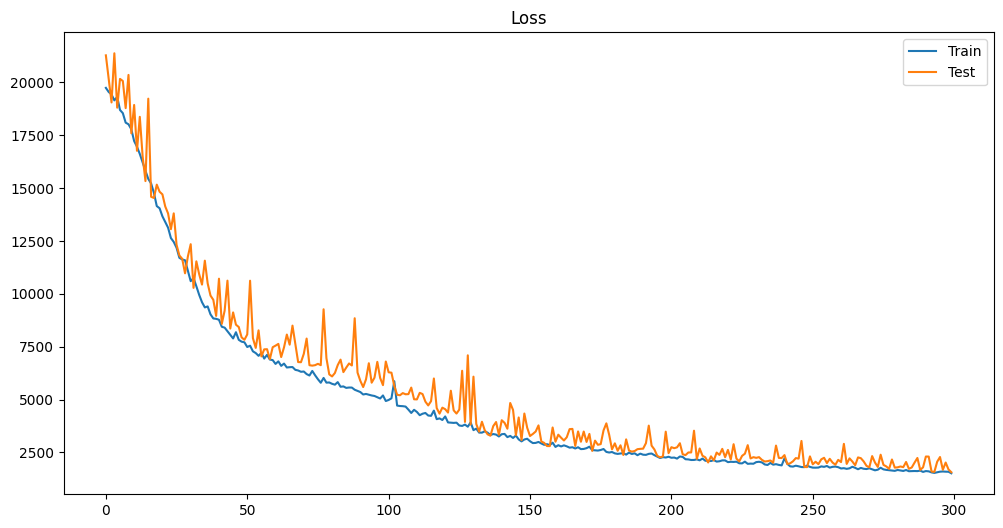

In [18]:
plt.figure(figsize=(12, 6))
plt.title("Loss")
plt.plot(range(epochs), train_loss_values, label="Train")
plt.plot(range(epochs), test_loss_values, label="Test")
plt.legend()